# MIS 583 Assignment 4: Self-supervised and transfer learning on CIFAR10

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm Ren-Di Wu, B104020009.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data Setup (5 points)

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    #######################################################################
    #        TODO: Implement rotate_img() - return the rotated img        #                           
    #######################################################################
    angles = {0: 0, 1: 90, 2: 180, 3: 270}
    if rot in angles:
        return transforms.functional.rotate(img, angles[rot])
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

    #######################################################################
    #                           End of your code                          #
    #######################################################################

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [23]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


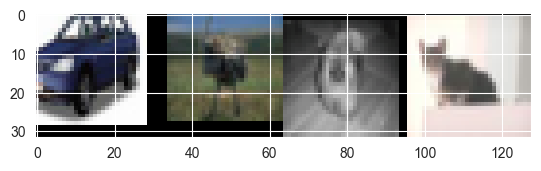

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  car   bird  dog   cat  


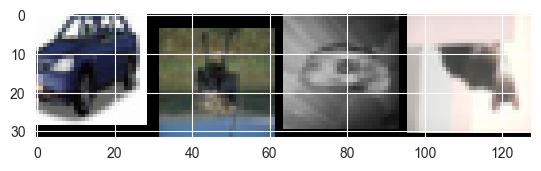

Rotation labels:  0     180   270   180  


In [24]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [15]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            #######################################################################
            # TODO: Calculate outputs by running images through the network       #
            # The class with the highest energy is what we choose as prediction   #
            #######################################################################
            # Calculate outputs by running images through the network
            outputs = net(images)

            # The class with the highest score is what we choose as our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [16]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task (9 points)

In this section, we will train a ResNet18 model **from scratch** on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Notice: You should not use pretrained weights from ImageNet.

In [28]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(weights = None, num_classes=4) # Do not modify this line.
net = net.to(device)
print(net) # print your model and check the num_classes is correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

In [18]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            ######################################################################################################
            # TODO: Set the data to the correct device; Different task will use different inputs and labels      #  
            # TODO: Zero the parameter gradients                                                                 #
            # TODO: forward + backward + optimize                                                                #
            # TODO: Get predicted results                                                                        #
            ######################################################################################################
            # Set data to the correct device
            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Get predicted results for accuracy calculation
            _, predicted = torch.max(outputs.data, 1)
            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################                                            


            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
        ######################################################################################################
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.          #
        ######################################################################################################
        # Evaluate the model after each epoch
        net.eval()
        run_test(net, testloader, criterion, task)
        ######################################################################################################
        #                               End of your code                                                     #
        ######################################################################################################  

    print('Finished Training')

In [31]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')
################################
#     TODO: Save the model     #  
################################
from datetime import datetime

# Get current date and time
current_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Save the model
model_path = f"model_{current_time}.pth"
torch.save(net.state_dict(), model_path)
################################
#      End of your code        #  
################################

[1,   100] loss: 1.519 acc: 31.64 time: 8.89
[1,   200] loss: 1.291 acc: 43.62 time: 7.72
[1,   300] loss: 1.217 acc: 48.27 time: 8.00
TESTING:
Accuracy of the network on the 10000 test images: 52.22 %
Average loss on the 10000 test images: 1.151
[2,   100] loss: 1.176 acc: 51.48 time: 7.93
[2,   200] loss: 1.166 acc: 52.25 time: 8.22
[2,   300] loss: 1.148 acc: 53.42 time: 7.75
TESTING:
Accuracy of the network on the 10000 test images: 54.94 %
Average loss on the 10000 test images: 1.137
[3,   100] loss: 1.135 acc: 54.34 time: 7.60
[3,   200] loss: 1.112 acc: 55.20 time: 8.97
[3,   300] loss: 1.097 acc: 56.84 time: 8.50
TESTING:
Accuracy of the network on the 10000 test images: 57.49 %
Average loss on the 10000 test images: 1.109
[4,   100] loss: 1.082 acc: 58.09 time: 8.13
[4,   200] loss: 1.072 acc: 58.38 time: 8.42
[4,   300] loss: 1.059 acc: 59.34 time: 8.67
TESTING:
Accuracy of the network on the 10000 test images: 58.75 %
Average loss on the 10000 test images: 1.089
[5,   100] l

## Fine-tuning on the pre-trained model (9 points)

In this section, we will load the ResNet18 model pre-trained on the rotation task and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [12]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #  
#####################################################
# load the trained classifier weights
ckpt = torch.load('model_2023-11-02-23-22-09.pth')
net.load_state_dict(ckpt)
print(net) # print your model and check the num_classes is correct
####################################################
#                End of your code                  #   
####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
#################################################################################################
#   TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable     #
#################################################################################################
# Freeze all parameters
net.requires_grad_(False)

# Adjusting the fully connected layer to have 10 outputs for 10 classes
net.fc = nn.Linear(net.fc.in_features, 10)  # Re-define the fc layer

# Unfreeze the last block (layer4) and the fully connected (fc) layer
net.layer4.requires_grad_(True)
net.fc.requires_grad_(True)

# Make sure to move the model to the device after modifying it
net.to(device)
#################################################################################################
#                                          End of your code                                     #
#################################################################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [15]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': net.layer4.parameters()},
    {'params': net.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [16]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 1.956 acc: 30.91 time: 6.90
[1,   200] loss: 1.740 acc: 41.34 time: 7.43
[1,   300] loss: 1.673 acc: 44.98 time: 7.52
TESTING:
Accuracy of the network on the 10000 test images: 47.17 %
Average loss on the 10000 test images: 1.626
[2,   100] loss: 1.621 acc: 47.38 time: 6.80
[2,   200] loss: 1.609 acc: 48.16 time: 7.47
[2,   300] loss: 1.587 acc: 49.48 time: 7.58
TESTING:
Accuracy of the network on the 10000 test images: 51.27 %
Average loss on the 10000 test images: 1.560
[3,   100] loss: 1.563 acc: 50.53 time: 6.84
[3,   200] loss: 1.564 acc: 51.20 time: 7.45
[3,   300] loss: 1.557 acc: 51.13 time: 7.54
TESTING:
Accuracy of the network on the 10000 test images: 53.10 %
Average loss on the 10000 test images: 1.512
[4,   100] loss: 1.560 acc: 50.59 time: 6.72
[4,   200] loss: 1.532 acc: 52.75 time: 7.38
[4,   300] loss: 1.537 acc: 52.34 time: 7.61
TESTING:
Accuracy of the network on the 10000 test images: 54.80 %
Average loss on the 10000 test images: 1.483
[5,   100] l

## Fine-tuning on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
# Randomly initialize a ResNet18 model
net = resnet18(pretrained=False)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
#################################################################################################
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable       #
# To do this, you should set requires_grad=False for the frozen layers.                         #
#################################################################################################
# Adjusting the fully connected layer for 10 classes
net.fc = nn.Linear(net.fc.in_features, 10)

# Freeze all layers in the randomly initialized model
net.requires_grad_(False)

# Unfreeze the last block (layer4) and the fully connected (fc) layer
net.layer4.requires_grad_(True)
net.fc.requires_grad_(True)

# Move the model to the device
net.to(device)
#################################################################################################
#                                          End of your code                                     #
#################################################################################################


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [20]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': net.layer4.parameters()},
    {'params': net.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [21]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.340 acc: 23.17 time: 6.85
[1,   200] loss: 2.033 acc: 29.73 time: 7.45
[1,   300] loss: 1.982 acc: 31.26 time: 7.58
TESTING:
Accuracy of the network on the 10000 test images: 35.74 %
Average loss on the 10000 test images: 1.879
[2,   100] loss: 1.917 acc: 34.38 time: 6.76
[2,   200] loss: 1.914 acc: 34.70 time: 7.45
[2,   300] loss: 1.892 acc: 35.75 time: 7.59
TESTING:
Accuracy of the network on the 10000 test images: 38.41 %
Average loss on the 10000 test images: 1.832
[3,   100] loss: 1.879 acc: 35.60 time: 6.79
[3,   200] loss: 1.878 acc: 35.94 time: 7.55
[3,   300] loss: 1.873 acc: 36.68 time: 7.58
TESTING:
Accuracy of the network on the 10000 test images: 38.75 %
Average loss on the 10000 test images: 1.825
[4,   100] loss: 1.855 acc: 37.27 time: 6.78
[4,   200] loss: 1.859 acc: 37.20 time: 7.53
[4,   300] loss: 1.843 acc: 38.43 time: 7.58
TESTING:
Accuracy of the network on the 10000 test images: 40.19 %
Average loss on the 10000 test images: 1.800
[5,   100] l

## Supervised training on the pre-trained model (9 points)
In this section, we will load the ResNet18 model pre-trained on the rotation task and re-train the whole model on the classification task.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [22]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #  
#####################################################
# load the trained classifier weights
net = resnet18(weights=None, num_classes=4)
ckpt = torch.load('model_2023-11-02-23-22-09.pth')
net.load_state_dict(ckpt)

# Adjusting the fully connected layer for 10 classes
net.fc = nn.Linear(net.fc.in_features, 10)
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#####################################################
#                End of your code                   #   
#####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam(lr=0.001, params=net.parameters())

criterion.to(device)

CrossEntropyLoss()

In [24]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.654 acc: 45.31 time: 7.22
[1,   200] loss: 1.385 acc: 60.48 time: 7.52
[1,   300] loss: 1.303 acc: 63.76 time: 7.40
TESTING:
Accuracy of the network on the 10000 test images: 66.45 %
Average loss on the 10000 test images: 1.259
[2,   100] loss: 1.220 acc: 67.86 time: 6.97
[2,   200] loss: 1.184 acc: 69.91 time: 7.37
[2,   300] loss: 1.174 acc: 69.82 time: 7.43
TESTING:
Accuracy of the network on the 10000 test images: 71.50 %
Average loss on the 10000 test images: 1.152
[3,   100] loss: 1.115 acc: 72.78 time: 7.13
[3,   200] loss: 1.103 acc: 73.30 time: 7.47
[3,   300] loss: 1.099 acc: 73.53 time: 7.53
TESTING:
Accuracy of the network on the 10000 test images: 74.93 %
Average loss on the 10000 test images: 1.073
[4,   100] loss: 1.061 acc: 74.88 time: 7.07
[4,   200] loss: 1.036 acc: 76.88 time: 7.41
[4,   300] loss: 1.056 acc: 75.31 time: 7.43
TESTING:
Accuracy of the network on the 10000 test images: 75.81 %
Average loss on the 10000 test images: 1.050
[5,   100] l

## Supervised training on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [25]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
net = resnet18(weights=None, num_classes=10)
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam(lr=0.001, params=net.parameters())

criterion.to(device)

CrossEntropyLoss()

In [27]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.279 acc: 23.41 time: 7.28
[1,   200] loss: 1.926 acc: 34.48 time: 7.56
[1,   300] loss: 1.802 acc: 39.67 time: 7.42
TESTING:
Accuracy of the network on the 10000 test images: 46.79 %
Average loss on the 10000 test images: 1.657
[2,   100] loss: 1.657 acc: 46.05 time: 7.21
[2,   200] loss: 1.618 acc: 48.73 time: 7.45
[2,   300] loss: 1.559 acc: 51.73 time: 7.45
TESTING:
Accuracy of the network on the 10000 test images: 56.04 %
Average loss on the 10000 test images: 1.464
[3,   100] loss: 1.441 acc: 57.27 time: 7.24
[3,   200] loss: 1.408 acc: 58.66 time: 7.42
[3,   300] loss: 1.371 acc: 60.68 time: 7.41
TESTING:
Accuracy of the network on the 10000 test images: 59.50 %
Average loss on the 10000 test images: 1.420
[4,   100] loss: 1.303 acc: 63.56 time: 7.22
[4,   200] loss: 1.285 acc: 64.72 time: 7.45
[4,   300] loss: 1.290 acc: 64.44 time: 7.43
TESTING:
Accuracy of the network on the 10000 test images: 69.16 %
Average loss on the 10000 test images: 1.188
[5,   100] l

# Write report (37 points)

本次作業主要有3個tasks需要大家完成，在A4.pdf中有希望大家達成的baseline **(不能低於baseline最多2%，沒有達到不會給全部分數)**，report的撰寫請大家根據以下要求完成，就請大家將嘗試的結果寫在report裡，祝大家順利！

1. (13 points) Train a ResNet18 on the Rotation task and report the test performance. Discuss why such a task helps in learning features that are generalizable to other visual tasks.

2. (12 points) Initializing from the Rotation model or from random weights, fine-tune only the weights of the final block of convolutional layers and linear layer on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights. You can also discuss how the performance of pre-trained models affects downstream tasks, the performance of fine-tuning different numbers of layers, and so on.

3. (12 points) Initializing from the Rotation model or from random weights, train the full network on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights.

# Extra Credit (13 points)

上面基本的code跟report最高可以拿到87分，這個加分部分並沒有要求同學們一定要做，若同學們想要獲得更高的分數可以根據以下的加分要求來獲得加分。

- In Figure 5(b) from the Gidaris et al. paper, the authors show a plot of CIFAR10 classification performance vs. number of training examples per category for a supervised CIFAR10 model vs. a RotNet model with the final layers fine-tuned on CIFAR10. The plot shows that pre-training on the Rotation task can be advantageous when only a small amount of labeled data is available. Using your RotNet fine-tuning code and supervised CIFAR10 training code from the main assignment, try to create a similar plot by performing supervised fine-tuning/training on only a subset of CIFAR10.
- Use a more advanced model than ResNet18 to try to get higher accuracy on the rotation prediction task, as well as for transfer to supervised CIFAR10 classification.
  
- If you have a good amount of compute at your disposal, try to train a rotation prediction model on the larger ImageNette dataset (still smaller than ImageNet, though).


# Defining a balanced subset of the training set (Extra Credit)

# Set up the environment

In [1]:
import pandas as pd
import torch
import numpy as np
import random

# Function to set the seed
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    random.seed(seed_value)

set_seed()

experience_name = 'self_supervised_sample_size'

# Define columns for the DataFrame
columns = ['Experiment Type', 'Epoch', 'Train Accuracy', 'Train Loss', 'Valid Accuracy', 'Valid Loss']

# Initialize an empty DataFrame with these columns
experience_report = pd.DataFrame(columns=columns)

# Define the transforms to apply to the data

In [2]:
import torchvision

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    #######################################################################
    #        TODO: Implement rotate_img() - return the rotated img        #
    #######################################################################
    angles = {0: 0, 1: 90, 2: 180, 3: 270}
    if rot in angles:
        return transforms.functional.rotate(img, angles[rot])
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

# Define the subset of the training set

In [4]:
from torch.utils.data import Subset
import torchvision.transforms as transforms
import random
import torch


def create_balanced_subset(dataset, num_samples_per_class):
    """
    Create a balanced subset of the dataset with a specific number of samples per class.

    :param dataset: The dataset from which to create the subset.
    :param num_samples_per_class: The number of samples to include from each class.
    :return: A Subset of the original dataset.
    """
    class_counts = {i: 0 for i in range(10)}  # Assuming CIFAR10 has 10 classes
    class_indices = {i: [] for i in range(10)}

    # Iterate over the dataset to collect class indices
    for idx in range(len(dataset)):
        _, _, _, cls_label = dataset[idx]
        cls_label = cls_label.item()  # Convert tensor to integer
        if class_counts[cls_label] < num_samples_per_class:
            class_counts[cls_label] += 1
            class_indices[cls_label].append(idx)
        if all(count == num_samples_per_class for count in class_counts.values()):
            break  # Early exit if we've collected enough samples for each class

    # Flatten the list of indices
    subset_indices = [idx for indices in class_indices.values() for idx in indices]

    return Subset(dataset, subset_indices)


# Define the transforms to apply to the data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Define the batch size
batch_size = 128

# Define the transforms to apply to the data
trainset = CIFAR10Rotation(root='./data', train=True,
                           download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

testset = CIFAR10Rotation(root='./data', train=False,
                          download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

# Create a balanced subset of the training set with 2 samples per class
balanced_trainset_20 = create_balanced_subset(trainset,
                                              num_samples_per_class=20)
balanced_trainloader_20 = torch.utils.data.DataLoader(balanced_trainset_20,
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


# Show some example images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels counts: {0: 10, 1: 11, 2: 13, 3: 17, 4: 15, 5: 7, 6: 12, 7: 17, 8: 12, 9: 14}
Labels counts: {0: 10, 1: 9, 2: 7, 3: 3, 4: 5, 5: 13, 6: 8, 7: 3, 8: 8, 9: 6}


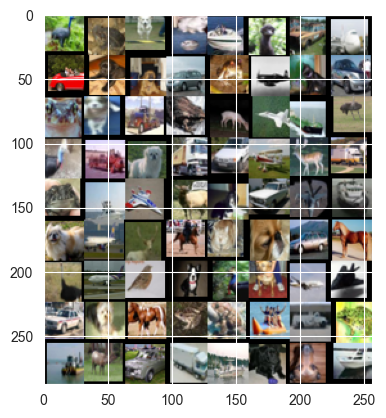

In [5]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    # Un-normalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_images_and_labels(data_loader):
    # Loop over the entire data_loader
    for iter_images, _, _, iter_labels in data_loader:
        # Print images
        imshow(torchvision.utils.make_grid(iter_images, padding=0))

        # Print labels
        labels_np = iter_labels.cpu().numpy()  # Convert to numpy array after moving to cpu
        unique_labels, counts = np.unique(labels_np, return_counts=True)
        print('Labels counts:', dict(zip(unique_labels, counts)))

show_images_and_labels(balanced_trainloader_20)

# Define train and test funtion

In [6]:
import time

def run_test(model, validloader, loss_function, task=None):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for iter_images, images_rotated, labels_set, cls_labels in validloader:
            if task == 'rotation':
              iter_images, labels_set = images_rotated.to(device), labels_set.to(device)
            else:
              iter_images, labels_set = iter_images.to(device), cls_labels.to(device)

            # Calculate outputs by running images through the network
            outputs = model(iter_images)

            # The class with the highest score is what we choose as our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels_set.size(0)
            correct += (predicted == labels_set).sum().item()
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += loss_function(outputs, labels_set) / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

    return avg_test_loss, 100 * correct / total

In [7]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
def train(model, loss_function, trainset_loader, train_optimizer, num_epochs, decay_epochs, init_lr, experiment_type=None, task=None):
    global experience_report
    best_valid_acc = 0.0  # Initialize best validation accuracy
    best_model_state = None  # Initialize best model state

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # Initialize epoch variables
        total_loss = 0.0
        total_correct = 0.0
        total_samples = 0.0

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        model.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainset_loader, 0):
            # Set data to the correct device
            if task == 'rotation':
                inputs, labels_set = imgs_rotated.to(device), rotation_label.to(device)
            else:
                inputs, labels_set = imgs.to(device), cls_label.to(device)

            adjust_learning_rate(train_optimizer, epoch, init_lr, decay_epochs)

            train_optimizer.zero_grad()  # Zero the parameter gradients

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = loss_function(outputs, labels_set)
            loss.backward()
            train_optimizer.step()

            # Get predicted results for accuracy calculation
            _, predicted = torch.max(outputs.data, 1)
            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################

            # print statisticss
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels_set.size(0)
            running_correct += (predicted == labels_set).sum().item()

            # Update total counts for epoch averages
            total_loss += loss.item()
            total_samples += labels_set.size(0)
            total_correct += (predicted == labels_set).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # Calculate average training loss and accuracy for the epoch
        avg_train_loss = total_loss / len(trainset_loader)
        avg_train_acc = 100 * total_correct / total_samples

        # Evaluate the model after each epoch
        model.eval()
        test_loss, test_acc = run_test(model, testloader, loss_function, task)

        # Check if this is the best model so far
        if test_acc > best_valid_acc:
            best_valid_acc = test_acc
            best_model_state = model.state_dict()  # Save the best model state

        # Append the epoch's results to the report DataFrame
        if experience_report is not None and experiment_type is not None:
            new_row = pd.DataFrame({
                'Experiment Type': [experiment_type],
                'Epoch': [epoch + 1],
                'Train Accuracy': [avg_train_acc.cpu().numpy()] if torch.is_tensor(avg_train_acc) else [avg_train_acc],
                'Train Loss': [avg_train_loss.cpu().numpy()] if torch.is_tensor(avg_train_loss) else [avg_train_loss],
                'Valid Accuracy': [test_acc.cpu().numpy()] if torch.is_tensor(test_acc) else [test_acc],
                'Valid Loss': [test_loss.cpu().numpy()] if torch.is_tensor(test_loss) else [test_loss]
            })
            experience_report = pd.concat([experience_report, new_row], ignore_index=True)

    # Restore the best model state
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f'Restored best model from epoch with validation accuracy: {best_valid_acc:.2f}%')

    # Save the report DataFrame after the experiment
    if experience_report is not None and experiment_type is not None:
        experience_report.to_csv(f'{experience_name}.csv', index=False)

    print('Finished Training')

# Define the reset for the model

In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, resnet34, resnet50

import torchvision.models as models
import torch.nn as nn

def load_pretrained_model(checkpoint_path, num_classes, select_device, model_type='resnet18', full_train=False):
    # Dynamic model initialization
    if model_type == 'resnet18':
        model = models.resnet18(weights=None, num_classes=4)
    elif model_type == 'resnet34':
        model = models.resnet34(weights=None, num_classes=4)
    elif model_type == 'resnet50':
        model = models.resnet50(weights=None, num_classes=4)
    else:
        model = models.resnet18(weights=None, num_classes=4)  # Default to resnet18 if model type is not recognized

    # Load the checkpoint
    model.load_state_dict(torch.load(checkpoint_path, map_location=select_device))

    # Full training or fine-tuning
    if full_train:
        # Unfreeze all layers for full training
        model.requires_grad_(True)  # Unfreeze all layers initially
    else:
        # Unfreeze only specific layers for fine-tuning
        model.requires_grad_(False)  # Freeze all layers initially
        if model_type in ['resnet18', 'resnet34', 'resnet50']:
            model.layer4.requires_grad_(True)  # Unfreeze the last block
            model.fc.requires_grad_(True)      # Unfreeze the fully connected layer

    # Retrieve the number of features for the fully connected layer
    model_features = model.fc.in_features

    # Adjust the fully connected layer for the new number of classes
    model.fc = nn.Linear(model_features, num_classes)

    # Move the model to the specified device
    model = model.to(select_device)

    return model

def load_random_init_model(num_classes, select_device, model_type='resnet18', full_train=True):
    # Dynamic model initialization
    if model_type == 'resnet18':
        model = models.resnet18(weights=None, num_classes=num_classes)
    elif model_type == 'resnet34':
        model = models.resnet34(weights=None, num_classes=num_classes)
    elif model_type == 'resnet50':
        model = models.resnet50(weights=None, num_classes=num_classes)
    else:
        model = models.resnet18(weights=None, num_classes=num_classes)
    # Add more elif clauses for other model types as needed

    # Full training or fine-tuning
    if full_train:
        # Unfreeze all layers for full training
        model.requires_grad_(True)  # Unfreeze all layers initially
    else:
        # Unfreeze only specific layers for fine-tuning
        model.requires_grad_(False)  # Freeze all layers initially
        if model_type in ['resnet18', 'resnet34', 'resnet50']:
            model.layer4.requires_grad_(True)  # Unfreeze the last block
            model.fc.requires_grad_(True)      # Unfreeze the fully connected layer

    # Move the model to the specified device
    model = model.to(select_device)

    return model


# Default Settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = 'model_2023-11-02-23-22-09.pth'

# Experience test of sample per class 20

In [142]:
# Create a balanced subset of the training set with 2 samples per class
balanced_trainset_20 = create_balanced_subset(trainset,
                                            num_samples_per_class=20)
balanced_trainloader_20 = torch.utils.data.DataLoader(balanced_trainset_20,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    num_workers=0)

# Load the model
pretrained_model = load_pretrained_model(model_path, 10, device)

# Load the random initialized model
random_init_model = load_random_init_model(10, device)

In [143]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': pretrained_model.layer4.parameters()},
    {'params': pretrained_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [144]:
# Train the pre-trained model on the classification task
train(pretrained_model, criterion, balanced_trainloader_20, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01, experiment_type='Pre-trained Model Sample Per Class 20')

TESTING:
Accuracy of the network on the 10000 test images: 13.28 %
Average loss on the 10000 test images: 2.257
TESTING:
Accuracy of the network on the 10000 test images: 14.37 %
Average loss on the 10000 test images: 2.221
TESTING:
Accuracy of the network on the 10000 test images: 17.37 %
Average loss on the 10000 test images: 2.204
TESTING:
Accuracy of the network on the 10000 test images: 18.23 %
Average loss on the 10000 test images: 2.207
TESTING:
Accuracy of the network on the 10000 test images: 20.89 %
Average loss on the 10000 test images: 2.198
TESTING:
Accuracy of the network on the 10000 test images: 20.77 %
Average loss on the 10000 test images: 2.196
TESTING:
Accuracy of the network on the 10000 test images: 19.85 %
Average loss on the 10000 test images: 2.190
TESTING:
Accuracy of the network on the 10000 test images: 20.76 %
Average loss on the 10000 test images: 2.167
TESTING:
Accuracy of the network on the 10000 test images: 22.14 %
Average loss on the 10000 test images

In [145]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(random_init_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [146]:
# Train the random init model on the classification task
train(random_init_model, criterion, balanced_trainloader_20, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01, experiment_type='Random Init Model Sample Per Class 20')

TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 21911.504
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 896655.000
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 241934.219
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 56451.594
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 21903.695
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 8282.464
TESTING:
Accuracy of the network on the 10000 test images: 10.02 %
Average loss on the 10000 test images: 3536.598
TESTING:
Accuracy of the network on the 10000 test images: 10.06 %
Average loss on the 10000 test images: 1476.895
TESTING:
Accuracy of the network on the 10000 test images: 10.18 %
Averag

# Experience test of sample per class 50

In [147]:
# Create a balanced subset of the training set with 50 samples per class
balanced_trainset_50 = create_balanced_subset(trainset,
                                              num_samples_per_class=50)
balanced_trainloader_50 = torch.utils.data.DataLoader(balanced_trainset_50,
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      num_workers=0)
# Load the model
pretrained_model = load_pretrained_model(model_path, 10, device)

# Load the random initialized model
random_init_model = load_random_init_model(10, device)

In [148]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': pretrained_model.layer4.parameters()},
    {'params': pretrained_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [149]:
# Train the pre-trained model on the classification task
train(pretrained_model, criterion, balanced_trainloader_50, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Pre-trained Model Sample Per Class 50')

TESTING:
Accuracy of the network on the 10000 test images: 16.95 %
Average loss on the 10000 test images: 2.230
TESTING:
Accuracy of the network on the 10000 test images: 19.31 %
Average loss on the 10000 test images: 2.175
TESTING:
Accuracy of the network on the 10000 test images: 21.04 %
Average loss on the 10000 test images: 2.148
TESTING:
Accuracy of the network on the 10000 test images: 24.88 %
Average loss on the 10000 test images: 2.075
TESTING:
Accuracy of the network on the 10000 test images: 26.28 %
Average loss on the 10000 test images: 2.025
TESTING:
Accuracy of the network on the 10000 test images: 26.94 %
Average loss on the 10000 test images: 2.042
TESTING:
Accuracy of the network on the 10000 test images: 28.07 %
Average loss on the 10000 test images: 2.008
TESTING:
Accuracy of the network on the 10000 test images: 28.70 %
Average loss on the 10000 test images: 2.004
TESTING:
Accuracy of the network on the 10000 test images: 30.09 %
Average loss on the 10000 test images

In [150]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(random_init_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [151]:
# Train the random init model on the classification task
train(random_init_model, criterion, balanced_trainloader_50, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Random Init Model Sample Per Class 50')

TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 349307.844
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 23499.836
TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 636.030
TESTING:
Accuracy of the network on the 10000 test images: 10.22 %
Average loss on the 10000 test images: 142.812
TESTING:
Accuracy of the network on the 10000 test images: 14.80 %
Average loss on the 10000 test images: 16.359
TESTING:
Accuracy of the network on the 10000 test images: 19.81 %
Average loss on the 10000 test images: 7.440
TESTING:
Accuracy of the network on the 10000 test images: 22.36 %
Average loss on the 10000 test images: 5.698
TESTING:
Accuracy of the network on the 10000 test images: 17.58 %
Average loss on the 10000 test images: 4.781
TESTING:
Accuracy of the network on the 10000 test images: 17.82 %
Average loss on the 100

# Experience test of sample per class 100

In [152]:
# Create a balanced subset of the training set with 100 samples per class
balanced_trainset_100 = create_balanced_subset(trainset,
                                            num_samples_per_class=100)
balanced_trainloader_100 = torch.utils.data.DataLoader(balanced_trainset_100,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    num_workers=0)

# Load the model
pretrained_model = load_pretrained_model(model_path, 10, device)

# Load the random initialized model
random_init_model = load_random_init_model(10, device)

In [153]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': pretrained_model.layer4.parameters()},
    {'params': pretrained_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [154]:
# Train the pre-trained model on the classification task
train(pretrained_model, criterion, balanced_trainloader_100, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Pre-trained Model Sample Per Class 100')

TESTING:
Accuracy of the network on the 10000 test images: 18.44 %
Average loss on the 10000 test images: 2.183
TESTING:
Accuracy of the network on the 10000 test images: 22.00 %
Average loss on the 10000 test images: 2.097
TESTING:
Accuracy of the network on the 10000 test images: 27.53 %
Average loss on the 10000 test images: 1.998
TESTING:
Accuracy of the network on the 10000 test images: 31.28 %
Average loss on the 10000 test images: 1.953
TESTING:
Accuracy of the network on the 10000 test images: 30.39 %
Average loss on the 10000 test images: 1.944
TESTING:
Accuracy of the network on the 10000 test images: 34.64 %
Average loss on the 10000 test images: 1.880
TESTING:
Accuracy of the network on the 10000 test images: 35.06 %
Average loss on the 10000 test images: 1.870
TESTING:
Accuracy of the network on the 10000 test images: 34.99 %
Average loss on the 10000 test images: 1.863
TESTING:
Accuracy of the network on the 10000 test images: 35.57 %
Average loss on the 10000 test images

In [155]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(random_init_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [156]:
# Train the random init model on the classification task
train(random_init_model, criterion, balanced_trainloader_100, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Random Init Model Sample Per Class 100')

TESTING:
Accuracy of the network on the 10000 test images: 10.00 %
Average loss on the 10000 test images: 161345.609
TESTING:
Accuracy of the network on the 10000 test images: 9.31 %
Average loss on the 10000 test images: 1583.161
TESTING:
Accuracy of the network on the 10000 test images: 9.93 %
Average loss on the 10000 test images: 261.348
TESTING:
Accuracy of the network on the 10000 test images: 13.78 %
Average loss on the 10000 test images: 38.533
TESTING:
Accuracy of the network on the 10000 test images: 23.87 %
Average loss on the 10000 test images: 4.082
TESTING:
Accuracy of the network on the 10000 test images: 28.31 %
Average loss on the 10000 test images: 2.401
TESTING:
Accuracy of the network on the 10000 test images: 29.16 %
Average loss on the 10000 test images: 1.978
TESTING:
Accuracy of the network on the 10000 test images: 31.13 %
Average loss on the 10000 test images: 1.989
TESTING:
Accuracy of the network on the 10000 test images: 32.19 %
Average loss on the 10000 te

# Experience test of sample per class 250

In [157]:
# Create a balanced subset of the training set with 250 samples per class
balanced_trainset_250 = create_balanced_subset(trainset,
                                                num_samples_per_class=250)
balanced_trainloader_250 = torch.utils.data.DataLoader(balanced_trainset_250,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=0)

# Load the model
pretrained_model = load_pretrained_model(model_path, 10, device)

# Load the random initialized model
random_init_model = load_random_init_model(10, device)

In [158]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': pretrained_model.layer4.parameters()},
    {'params': pretrained_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [159]:
# Train the pre-trained model on the classification task
train(pretrained_model, criterion, balanced_trainloader_250, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Pre-trained Model Sample Per Class 250')

TESTING:
Accuracy of the network on the 10000 test images: 22.94 %
Average loss on the 10000 test images: 2.082
TESTING:
Accuracy of the network on the 10000 test images: 31.80 %
Average loss on the 10000 test images: 1.957
TESTING:
Accuracy of the network on the 10000 test images: 36.11 %
Average loss on the 10000 test images: 1.849
TESTING:
Accuracy of the network on the 10000 test images: 38.09 %
Average loss on the 10000 test images: 1.830
TESTING:
Accuracy of the network on the 10000 test images: 38.54 %
Average loss on the 10000 test images: 1.810
TESTING:
Accuracy of the network on the 10000 test images: 40.58 %
Average loss on the 10000 test images: 1.756
TESTING:
Accuracy of the network on the 10000 test images: 41.50 %
Average loss on the 10000 test images: 1.779
TESTING:
Accuracy of the network on the 10000 test images: 43.27 %
Average loss on the 10000 test images: 1.713
TESTING:
Accuracy of the network on the 10000 test images: 43.60 %
Average loss on the 10000 test images

In [160]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(random_init_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [161]:
# Train the random init model on the classification task
train(random_init_model, criterion, balanced_trainloader_250, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Random Init Model Sample Per Class 250')

TESTING:
Accuracy of the network on the 10000 test images: 10.03 %
Average loss on the 10000 test images: 529.041
TESTING:
Accuracy of the network on the 10000 test images: 18.45 %
Average loss on the 10000 test images: 6.144
TESTING:
Accuracy of the network on the 10000 test images: 24.77 %
Average loss on the 10000 test images: 2.048
TESTING:
Accuracy of the network on the 10000 test images: 31.23 %
Average loss on the 10000 test images: 1.979
TESTING:
Accuracy of the network on the 10000 test images: 33.49 %
Average loss on the 10000 test images: 1.881
TESTING:
Accuracy of the network on the 10000 test images: 28.95 %
Average loss on the 10000 test images: 2.022
TESTING:
Accuracy of the network on the 10000 test images: 32.66 %
Average loss on the 10000 test images: 1.949
TESTING:
Accuracy of the network on the 10000 test images: 34.42 %
Average loss on the 10000 test images: 1.910
TESTING:
Accuracy of the network on the 10000 test images: 31.37 %
Average loss on the 10000 test imag

# Experience test of sample per class 400

In [162]:
# Create a balanced subset of the training set with 400 samples per class
balanced_trainset_400 = create_balanced_subset(trainset,
                                            num_samples_per_class=400)
balanced_trainloader_400 = torch.utils.data.DataLoader(balanced_trainset_400,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    num_workers=0)

# Load the model
pretrained_model = load_pretrained_model(model_path, 10, device)

# Load the random initialized model
random_init_model = load_random_init_model(10, device)

In [163]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': pretrained_model.layer4.parameters()},
    {'params': pretrained_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [164]:
# Train the pre-trained model on the classification task
train(pretrained_model, criterion, balanced_trainloader_400, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Pre-trained Model Sample Per Class 400')

TESTING:
Accuracy of the network on the 10000 test images: 28.48 %
Average loss on the 10000 test images: 2.055
TESTING:
Accuracy of the network on the 10000 test images: 35.91 %
Average loss on the 10000 test images: 1.843
TESTING:
Accuracy of the network on the 10000 test images: 39.90 %
Average loss on the 10000 test images: 1.794
TESTING:
Accuracy of the network on the 10000 test images: 39.91 %
Average loss on the 10000 test images: 1.813
TESTING:
Accuracy of the network on the 10000 test images: 43.80 %
Average loss on the 10000 test images: 1.711
TESTING:
Accuracy of the network on the 10000 test images: 42.11 %
Average loss on the 10000 test images: 1.773
TESTING:
Accuracy of the network on the 10000 test images: 44.23 %
Average loss on the 10000 test images: 1.701
TESTING:
Accuracy of the network on the 10000 test images: 47.42 %
Average loss on the 10000 test images: 1.647
TESTING:
Accuracy of the network on the 10000 test images: 46.98 %
Average loss on the 10000 test images

In [165]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(random_init_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [166]:
# Train the random init model on the classification task
train(random_init_model, criterion, balanced_trainloader_400, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Random Init Model Sample Per Class 400')

TESTING:
Accuracy of the network on the 10000 test images: 16.11 %
Average loss on the 10000 test images: 3.059
TESTING:
Accuracy of the network on the 10000 test images: 31.87 %
Average loss on the 10000 test images: 2.558
TESTING:
Accuracy of the network on the 10000 test images: 28.19 %
Average loss on the 10000 test images: 4.494
TESTING:
Accuracy of the network on the 10000 test images: 34.45 %
Average loss on the 10000 test images: 1.891
TESTING:
Accuracy of the network on the 10000 test images: 23.00 %
Average loss on the 10000 test images: 2.676
TESTING:
Accuracy of the network on the 10000 test images: 33.61 %
Average loss on the 10000 test images: 5.389
TESTING:
Accuracy of the network on the 10000 test images: 38.32 %
Average loss on the 10000 test images: 1.876
TESTING:
Accuracy of the network on the 10000 test images: 41.50 %
Average loss on the 10000 test images: 1.728
TESTING:
Accuracy of the network on the 10000 test images: 36.58 %
Average loss on the 10000 test images

# Experience test of sample per class 700

In [167]:
# Create a balanced subset of the training set with 700 samples per class
balanced_trainset_700 = create_balanced_subset(trainset,
                                                num_samples_per_class=700)
balanced_trainloader_700 = torch.utils.data.DataLoader(balanced_trainset_700,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        num_workers=0)

# Load the model
pretrained_model = load_pretrained_model(model_path, 10, device)

# Load the random initialized model
random_init_model = load_random_init_model(10, device)

In [168]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': pretrained_model.layer4.parameters()},
    {'params': pretrained_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [169]:
# Train the pre-trained model on the classification task
train(pretrained_model, criterion, balanced_trainloader_700, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Pre-trained Model Sample Per Class 700')

TESTING:
Accuracy of the network on the 10000 test images: 33.73 %
Average loss on the 10000 test images: 1.893
TESTING:
Accuracy of the network on the 10000 test images: 39.63 %
Average loss on the 10000 test images: 1.772
TESTING:
Accuracy of the network on the 10000 test images: 43.01 %
Average loss on the 10000 test images: 1.737
TESTING:
Accuracy of the network on the 10000 test images: 44.51 %
Average loss on the 10000 test images: 1.682
TESTING:
Accuracy of the network on the 10000 test images: 47.22 %
Average loss on the 10000 test images: 1.633
TESTING:
Accuracy of the network on the 10000 test images: 48.63 %
Average loss on the 10000 test images: 1.604
TESTING:
Accuracy of the network on the 10000 test images: 48.84 %
Average loss on the 10000 test images: 1.599
TESTING:
Accuracy of the network on the 10000 test images: 50.11 %
Average loss on the 10000 test images: 1.572
TESTING:
Accuracy of the network on the 10000 test images: 49.22 %
Average loss on the 10000 test images

In [170]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(random_init_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [171]:
# Train the random init model on the classification task
train(random_init_model, criterion, balanced_trainloader_700, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Random Init Model Sample Per Class 700')

TESTING:
Accuracy of the network on the 10000 test images: 25.86 %
Average loss on the 10000 test images: 2.342
TESTING:
Accuracy of the network on the 10000 test images: 30.27 %
Average loss on the 10000 test images: 1.988
TESTING:
Accuracy of the network on the 10000 test images: 33.61 %
Average loss on the 10000 test images: 2.808
TESTING:
Accuracy of the network on the 10000 test images: 31.22 %
Average loss on the 10000 test images: 3.201
TESTING:
Accuracy of the network on the 10000 test images: 39.20 %
Average loss on the 10000 test images: 1.829
TESTING:
Accuracy of the network on the 10000 test images: 41.97 %
Average loss on the 10000 test images: 1.788
TESTING:
Accuracy of the network on the 10000 test images: 38.81 %
Average loss on the 10000 test images: 1.795
TESTING:
Accuracy of the network on the 10000 test images: 43.95 %
Average loss on the 10000 test images: 1.668
TESTING:
Accuracy of the network on the 10000 test images: 44.02 %
Average loss on the 10000 test images

# Experience test of sample per class 1000

In [172]:
# Create a balanced subset of the training set with 1000 samples per class
balanced_trainset_1000 = create_balanced_subset(trainset,
                                            num_samples_per_class=1000)
balanced_trainloader_1000 = torch.utils.data.DataLoader(balanced_trainset_1000,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    num_workers=0)

# Load the model
pretrained_model = load_pretrained_model(model_path, 10, device)

# Load the random initialized model
random_init_model = load_random_init_model(10, device)

In [173]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': pretrained_model.layer4.parameters()},
    {'params': pretrained_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [174]:
# Train the pre-trained model on the classification task
train(pretrained_model, criterion, balanced_trainloader_1000, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Pre-trained Model Sample Per Class 1000')

TESTING:
Accuracy of the network on the 10000 test images: 37.90 %
Average loss on the 10000 test images: 1.818
TESTING:
Accuracy of the network on the 10000 test images: 43.94 %
Average loss on the 10000 test images: 1.697
TESTING:
Accuracy of the network on the 10000 test images: 44.57 %
Average loss on the 10000 test images: 1.679
TESTING:
Accuracy of the network on the 10000 test images: 48.24 %
Average loss on the 10000 test images: 1.608
TESTING:
Accuracy of the network on the 10000 test images: 48.39 %
Average loss on the 10000 test images: 1.610
TESTING:
Accuracy of the network on the 10000 test images: 50.10 %
Average loss on the 10000 test images: 1.571
TESTING:
Accuracy of the network on the 10000 test images: 50.04 %
Average loss on the 10000 test images: 1.591
TESTING:
Accuracy of the network on the 10000 test images: 48.09 %
Average loss on the 10000 test images: 1.622
TESTING:
Accuracy of the network on the 10000 test images: 50.55 %
Average loss on the 10000 test images

In [175]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(random_init_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [176]:
# Train the random init model on the classification task
train(random_init_model, criterion, balanced_trainloader_1000, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Random Init Model Sample Per Class 1000')

TESTING:
Accuracy of the network on the 10000 test images: 25.91 %
Average loss on the 10000 test images: 2.086
TESTING:
Accuracy of the network on the 10000 test images: 23.06 %
Average loss on the 10000 test images: 2.266
TESTING:
Accuracy of the network on the 10000 test images: 36.24 %
Average loss on the 10000 test images: 1.918
TESTING:
Accuracy of the network on the 10000 test images: 35.12 %
Average loss on the 10000 test images: 1.927
TESTING:
Accuracy of the network on the 10000 test images: 39.45 %
Average loss on the 10000 test images: 1.782
TESTING:
Accuracy of the network on the 10000 test images: 44.36 %
Average loss on the 10000 test images: 1.710
TESTING:
Accuracy of the network on the 10000 test images: 44.47 %
Average loss on the 10000 test images: 1.704
TESTING:
Accuracy of the network on the 10000 test images: 49.16 %
Average loss on the 10000 test images: 1.593
TESTING:
Accuracy of the network on the 10000 test images: 45.64 %
Average loss on the 10000 test images

# Load the report DataFrame

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set the style of seaborn and matplotlib
sns.set_style("whitegrid")

# Read the CSV file into DataFrames
report = pd.read_csv('self_supervised_sample_size.csv')

# Assuming the number is always followed by "Sample Per Class"
report['Samples Per Class'] = report['Experiment Type'].apply(lambda x: int(re.search(r'(\d+)', x).group()))

report.head()

,Experiment Type,Epoch,Train Accuracy,Train Loss,Valid Accuracy,Valid Loss,Samples Per Class
0,Pre-trained Model Sample Per Class 20,1,12.0,2.294805,13.28,2.257233,20
1,Pre-trained Model Sample Per Class 20,2,16.0,2.217528,14.37,2.221031,20
2,Pre-trained Model Sample Per Class 20,3,23.5,2.133584,17.37,2.204279,20
3,Pre-trained Model Sample Per Class 20,4,21.0,2.069723,18.23,2.206506,20
4,Pre-trained Model Sample Per Class 20,5,24.0,2.030101,20.89,2.198455,20


In [25]:
report.tail()

,Experiment Type,Epoch,Train Accuracy,Train Loss,Valid Accuracy,Valid Loss,Samples Per Class
1115,Random Init Model Sample Per Class 1000,76,71.73,1.130748,66.19,1.260392,1000
1116,Random Init Model Sample Per Class 1000,77,71.45,1.143611,66.03,1.263182,1000
1117,Random Init Model Sample Per Class 1000,78,70.58,1.149814,65.91,1.263294,1000
1118,Random Init Model Sample Per Class 1000,79,71.04,1.139862,65.96,1.261516,1000
1119,Random Init Model Sample Per Class 1000,80,71.25,1.142457,66.27,1.264508,1000


# Plot the validation accuracy and loss for the two different experiment types

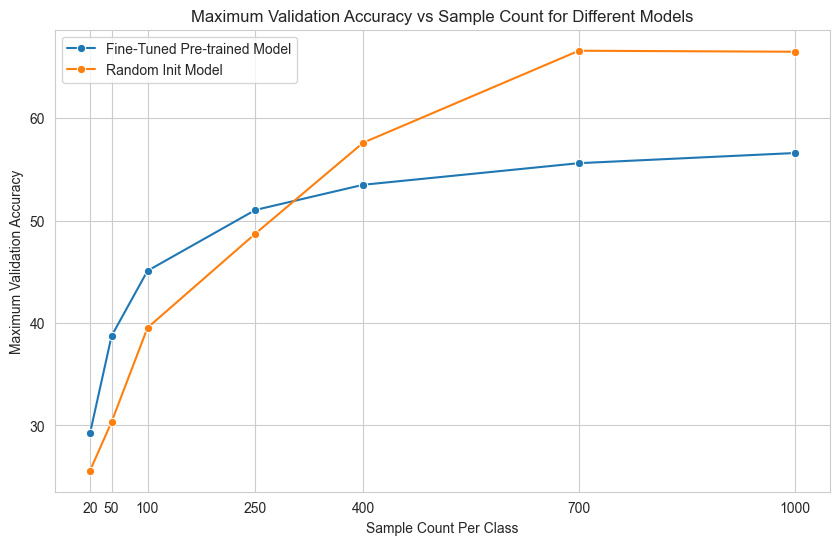

In [26]:
# Filtering data for the two different experiment types
fine_tuned_data = report[report['Experiment Type'].str.contains('Pre-trained')]
random_init_data = report[report['Experiment Type'].str.contains('Random Init')]

# Grouping the data to find maximum validation accuracy for each sample count and experiment type
max_valid_accuracy_fine_tuned = fine_tuned_data.groupby('Experiment Type')['Valid Accuracy'].max()
max_valid_accuracy_random_init = random_init_data.groupby('Experiment Type')['Valid Accuracy'].max()

# Extracting sample count from the experiment type
sample_count_fine_tuned = max_valid_accuracy_fine_tuned.index.str.extract('(\d+)').astype(int).squeeze()
sample_count_random_init = max_valid_accuracy_random_init.index.str.extract('(\d+)').astype(int).squeeze()

# Adjusting the previous validation accuracy plot to show the sample count on the x-axis ticks
plt.figure(figsize=(10, 6))
sns.lineplot(x=sample_count_fine_tuned, y=max_valid_accuracy_fine_tuned.values, marker='o', label='Fine-Tuned Pre-trained Model')
sns.lineplot(x=sample_count_random_init, y=max_valid_accuracy_random_init.values, marker='o', label='Random Init Model')

# Setting the x-axis ticks to show the sample counts
plt.xticks(sample_count_fine_tuned)

plt.xlabel('Sample Count Per Class')
plt.ylabel('Maximum Validation Accuracy')
plt.title('Maximum Validation Accuracy vs Sample Count for Different Models')
plt.legend()
plt.grid(True)
plt.savefig('Plot/sample_size_accuracy.png')
plt.show()

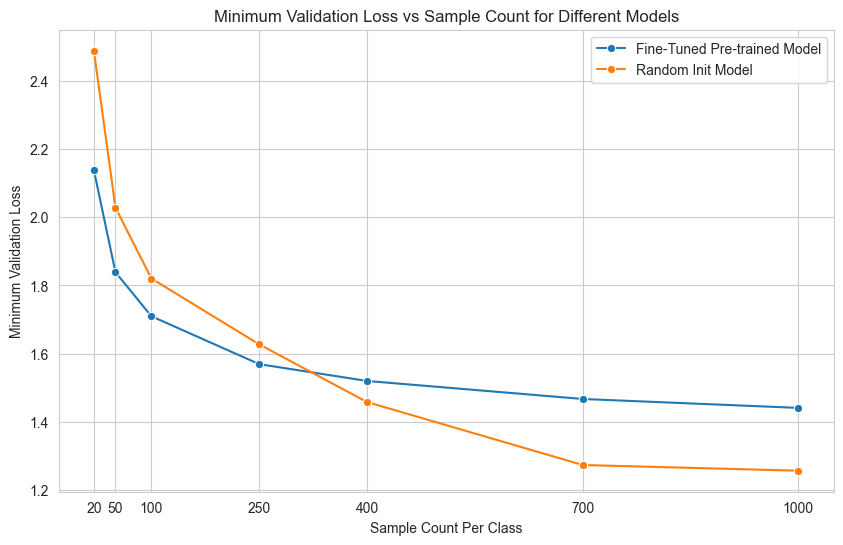

In [27]:
# For creating a new plot of the validation loss with sample points, we'll extract the relevant data again
# Grouping the data to find minimum validation loss for each sample count and experiment type
min_valid_loss_fine_tuned = fine_tuned_data.groupby('Experiment Type')['Valid Loss'].min()
min_valid_loss_random_init = random_init_data.groupby('Experiment Type')['Valid Loss'].min()

# Adjusting the plot to show the sample count on the x-axis ticks
# Plotting the two lines with markers for each sample point
plt.figure(figsize=(10, 6))
sns.lineplot(x=sample_count_fine_tuned, y=min_valid_loss_fine_tuned.values, marker='o', label='Fine-Tuned Pre-trained Model')
sns.lineplot(x=sample_count_random_init, y=min_valid_loss_random_init.values, marker='o', label='Random Init Model')

# Setting the x-axis ticks to show the sample counts
plt.xticks(sample_count_fine_tuned)

plt.xlabel('Sample Count Per Class')
plt.ylabel('Minimum Validation Loss')
plt.title('Minimum Validation Loss vs Sample Count for Different Models')
plt.legend()
plt.grid(True)
plt.savefig('Plot/sample_size_loss.png')
plt.show()

In [30]:
# First, we extract the maximum validation accuracy and minimum validation loss for each sample size for both experiment types
fine_tuned_max_accuracy = fine_tuned_data.groupby('Samples Per Class')['Valid Accuracy'].max()
fine_tuned_min_loss = fine_tuned_data.groupby('Samples Per Class')['Valid Loss'].min()

random_init_max_accuracy = random_init_data.groupby('Samples Per Class')['Valid Accuracy'].max()
random_init_min_loss = random_init_data.groupby('Samples Per Class')['Valid Loss'].min()

# Then we create a dataframe from the series
fine_tuned_df = pd.DataFrame({
    'Fine-Tuned Max Accuracy': fine_tuned_max_accuracy,
    'Fine-Tuned Min Loss': fine_tuned_min_loss
})

random_init_df = pd.DataFrame({
    'Random Init Max Accuracy': random_init_max_accuracy,
    'Random Init Min Loss': random_init_min_loss
})

# Combine the dataframes to have a single dataframe with all the information
combined_df = fine_tuned_df.join(random_init_df)

combined_df.reset_index(inplace=True)

# Display the dataframe
combined_df

,Samples Per Class,Fine-Tuned Max Accuracy,Fine-Tuned Min Loss,Random Init Max Accuracy,Random Init Min Loss
0,20,29.23,2.138032,25.58,2.488180
1,50,38.74,1.838742,30.34,2.028229
2,100,45.10,1.709641,39.54,1.820254
3,250,51.04,1.569083,48.73,1.627147
4,400,53.50,1.519837,57.61,1.457984
5,700,55.61,1.467011,66.59,1.273388
6,1000,56.60,1.440840,66.49,1.256633


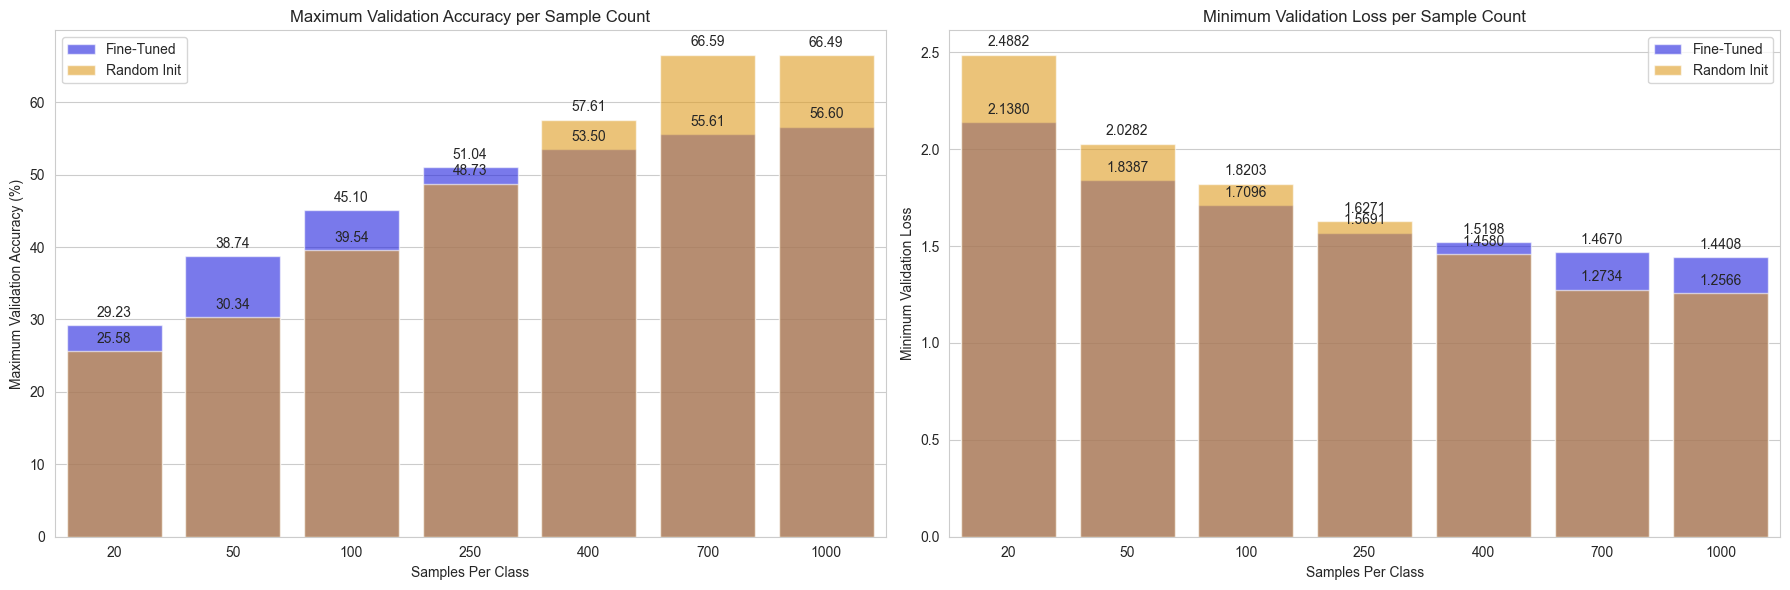

In [31]:
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plotting the accuracy with alpha for transparency
sns.barplot(x='Samples Per Class', y='Fine-Tuned Max Accuracy', data=combined_df, ax=axes[0], color='blue', label='Fine-Tuned', alpha=0.6)
sns.barplot(x='Samples Per Class', y='Random Init Max Accuracy', data=combined_df, ax=axes[0], color='orange', label='Random Init', alpha=0.6)

# Adding the text on the bars
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center',
                     va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

axes[0].set_title('Maximum Validation Accuracy per Sample Count')
axes[0].set_ylabel('Maximum Validation Accuracy (%)')
axes[0].set_xlabel('Samples Per Class')
axes[0].legend()

# Plotting the loss with alpha for transparency
sns.barplot(x='Samples Per Class', y='Fine-Tuned Min Loss', data=combined_df, ax=axes[1], color='blue', label='Fine-Tuned', alpha=0.6)
sns.barplot(x='Samples Per Class', y='Random Init Min Loss', data=combined_df, ax=axes[1], color='orange', label='Random Init', alpha=0.6)

# Adding the text on the bars
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.4f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center',
                     va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

axes[1].set_title('Minimum Validation Loss per Sample Count')
axes[1].set_ylabel('Minimum Validation Loss')
axes[1].set_xlabel('Samples Per Class')
axes[1].legend()

# Adjusting layout
plt.tight_layout()

# Save the plot with annotations
annotated_plot_path = 'Plot/annotated_accuracy_loss_comparison.png'
plt.savefig(annotated_plot_path)

plt.show()

In [40]:
# APA style typically requires tables to be simple and clear, without excessive styling or use of color.
# We will create a table style that adheres to this principle.

# Define the APA style for the table
apa_style = [
    # Table styles
    {'selector': 'table', 'props': [('border', 'none'), ('border-collapse', 'collapse')]},
    # Header styles
    {'selector': 'thead', 'props': [('border-bottom', '1px solid black')]},
    # Data cell styles
    {'selector': 'td', 'props': [('border', 'none')]},
    # Caption styles (placed at the bottom)
    {'selector': 'caption', 'props': [('caption-side', 'bottom'), ('font-style', 'italic'), ('text-align', 'center')]}
]

# Apply the APA style to the dataframe and format the numbers
apa_styled_table = combined_df.style.\
    set_table_styles(apa_style).\
    format("{:.2f}", subset=pd.IndexSlice[:, ['Fine-Tuned Max Accuracy', 'Random Init Max Accuracy']]).\
    format("{:.4f}", subset=pd.IndexSlice[:, ['Fine-Tuned Min Loss', 'Random Init Min Loss']]).\
    hide().\
    set_caption("Table 1: Maximum Validation Accuracy and Minimum Validation Loss")

# Display the APA styled table
apa_styled_table

Samples Per Class,Fine-Tuned Max Accuracy,Fine-Tuned Min Loss,Random Init Max Accuracy,Random Init Min Loss
20,29.23,2.1380,25.58,2.4882
50,38.74,1.8387,30.34,2.0282
100,45.10,1.7096,39.54,1.8203
250,51.04,1.5691,48.73,1.6271
400,53.50,1.5198,57.61,1.4580
700,55.61,1.4670,66.59,1.2734
1000,56.60,1.4408,66.49,1.2566


# Test the self-supervised with a larger model

In [11]:
experience_name = 'compare_larger_model'

# Self-supervised with a larger model

## Resnet18

In [56]:
import torchvision.models as models
import torch.nn as nn

# Choose model
resnet18_model = models.resnet18(pretrained=False)
# Modify the final layer for your specific task (rotation prediction)
num_features = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_features, 4)

resnet18_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [62]:
train(resnet18_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Resnet18 Self-Supervise Rotation Model', task='rotation')

[1,   100] loss: 1.098 acc: 56.62 time: 10.42
[1,   200] loss: 1.089 acc: 57.30 time: 9.40
[1,   300] loss: 1.077 acc: 57.95 time: 9.40
TESTING:
Accuracy of the network on the 10000 test images: 58.16 %
Average loss on the 10000 test images: 1.087
[2,   100] loss: 1.061 acc: 59.34 time: 7.00
[2,   200] loss: 1.063 acc: 58.85 time: 7.41
[2,   300] loss: 1.043 acc: 60.55 time: 7.36
TESTING:
Accuracy of the network on the 10000 test images: 61.22 %
Average loss on the 10000 test images: 1.032
[3,   100] loss: 1.035 acc: 60.81 time: 7.15
[3,   200] loss: 1.023 acc: 61.41 time: 7.37
[3,   300] loss: 1.023 acc: 61.80 time: 8.21
TESTING:
Accuracy of the network on the 10000 test images: 62.99 %
Average loss on the 10000 test images: 0.988
[4,   100] loss: 1.014 acc: 62.68 time: 7.00
[4,   200] loss: 1.013 acc: 61.99 time: 7.51
[4,   300] loss: 0.994 acc: 63.31 time: 7.49
TESTING:
Accuracy of the network on the 10000 test images: 65.19 %
Average loss on the 10000 test images: 0.966
[5,   100] 

In [63]:
# Save the model
model_path = f"model_resnet18.pth"
torch.save(resnet18_model.state_dict(), model_path)

## Resnet34

In [12]:
import torchvision.models as models
import torch.nn as nn

# Choose model
resnet34_model = models.resnet34(pretrained=False)
# Modify the final layer for your specific task (rotation prediction)
num_features = resnet34_model.fc.in_features
resnet34_model.fc = nn.Linear(num_features, 4)

resnet34_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(resnet34_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [14]:
train(resnet34_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Resnet34 Self-Supervise Rotation Model', task='rotation')

[1,   100] loss: 1.709 acc: 25.70 time: 24.48
[1,   200] loss: 1.411 acc: 34.18 time: 8.95
[1,   300] loss: 1.358 acc: 41.27 time: 9.28
TESTING:
Accuracy of the network on the 10000 test images: 47.23 %
Average loss on the 10000 test images: 1.364
[2,   100] loss: 1.269 acc: 46.38 time: 8.89
[2,   200] loss: 1.251 acc: 47.07 time: 7.92
[2,   300] loss: 1.220 acc: 48.21 time: 7.79
TESTING:
Accuracy of the network on the 10000 test images: 52.53 %
Average loss on the 10000 test images: 1.268
[3,   100] loss: 1.194 acc: 49.65 time: 8.46
[3,   200] loss: 1.312 acc: 37.66 time: 8.19
[3,   300] loss: 1.306 acc: 39.44 time: 8.66
TESTING:
Accuracy of the network on the 10000 test images: 49.93 %
Average loss on the 10000 test images: 1.180
[4,   100] loss: 1.191 acc: 49.55 time: 8.37
[4,   200] loss: 1.158 acc: 52.34 time: 8.00
[4,   300] loss: 1.158 acc: 53.05 time: 8.05
TESTING:
Accuracy of the network on the 10000 test images: 55.63 %
Average loss on the 10000 test images: 1.116
[5,   100] 

In [15]:
# Save the model
model_path = f"model_resnet34.pth"
torch.save(resnet34_model.state_dict(), model_path)

## Resnet50

In [16]:
import torchvision.models as models
import torch.nn as nn

# Choose model
resnet50_model = models.resnet50(pretrained=False)
# Modify the final layer for your specific task (rotation prediction)
num_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_features, 4)

resnet50_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [18]:
train(resnet50_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=15, init_lr=0.01,
      experiment_type='Resnet50 Self-Supervise Rotation Model', task='rotation')

[1,   100] loss: 2.326 acc: 26.42 time: 9.10
[1,   200] loss: 1.520 acc: 33.22 time: 15.89
[1,   300] loss: 1.441 acc: 38.31 time: 10.38
TESTING:
Accuracy of the network on the 10000 test images: 42.94 %
Average loss on the 10000 test images: 1.268
[2,   100] loss: 1.319 acc: 42.62 time: 9.22
[2,   200] loss: 1.279 acc: 44.85 time: 8.91
[2,   300] loss: 1.235 acc: 47.24 time: 9.18
TESTING:
Accuracy of the network on the 10000 test images: 49.48 %
Average loss on the 10000 test images: 1.215
[3,   100] loss: 1.205 acc: 48.61 time: 8.99
[3,   200] loss: 1.190 acc: 49.98 time: 8.93
[3,   300] loss: 1.189 acc: 49.70 time: 8.80
TESTING:
Accuracy of the network on the 10000 test images: 54.04 %
Average loss on the 10000 test images: 1.145
[4,   100] loss: 1.155 acc: 52.82 time: 8.88
[4,   200] loss: 1.155 acc: 53.26 time: 8.74
[4,   300] loss: 1.143 acc: 53.42 time: 8.84
TESTING:
Accuracy of the network on the 10000 test images: 56.69 %
Average loss on the 10000 test images: 1.112
[5,   100]

In [19]:
# Save the model
model_path = f"model_resnet50.pth"
torch.save(resnet50_model.state_dict(), model_path)

# Test the self-supervised with a larger model in fine-tuning final layer

## Resnet18

In [64]:
resnet18_model = load_pretrained_model('model_resnet18.pth', 10, device, model_type='resnet18', full_train=False)

In [65]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': resnet18_model.layer4.parameters()},
    {'params': resnet18_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [66]:
train(resnet18_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet18 Fine-tuning Pre-trained Model')

[1,   100] loss: 1.928 acc: 32.79 time: 6.87
[1,   200] loss: 1.716 acc: 43.10 time: 7.64
[1,   300] loss: 1.652 acc: 46.59 time: 7.48
TESTING:
Accuracy of the network on the 10000 test images: 49.33 %
Average loss on the 10000 test images: 1.590
[2,   100] loss: 1.608 acc: 48.44 time: 7.99
[2,   200] loss: 1.576 acc: 49.88 time: 8.41
[2,   300] loss: 1.571 acc: 50.38 time: 10.40
TESTING:
Accuracy of the network on the 10000 test images: 51.82 %
Average loss on the 10000 test images: 1.534
[3,   100] loss: 1.556 acc: 51.32 time: 8.10
[3,   200] loss: 1.546 acc: 51.65 time: 8.29
[3,   300] loss: 1.551 acc: 51.34 time: 8.60
TESTING:
Accuracy of the network on the 10000 test images: 53.17 %
Average loss on the 10000 test images: 1.510
[4,   100] loss: 1.527 acc: 52.47 time: 8.31
[4,   200] loss: 1.537 acc: 52.32 time: 7.94
[4,   300] loss: 1.528 acc: 52.42 time: 8.27
TESTING:
Accuracy of the network on the 10000 test images: 55.76 %
Average loss on the 10000 test images: 1.466
[5,   100] 

## Resnet34

In [20]:
resnet34_model = load_pretrained_model('model_resnet34.pth', 10, device, model_type='resnet34', full_train=False)

In [21]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': resnet34_model.layer4.parameters()},
    {'params': resnet34_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [22]:
train(resnet34_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet34 Fine-tuning Pre-trained Model')

[1,   100] loss: 2.021 acc: 28.03 time: 8.27
[1,   200] loss: 1.839 acc: 36.72 time: 8.17
[1,   300] loss: 1.799 acc: 38.83 time: 8.10
TESTING:
Accuracy of the network on the 10000 test images: 43.08 %
Average loss on the 10000 test images: 1.753
[2,   100] loss: 1.755 acc: 40.88 time: 7.69
[2,   200] loss: 1.733 acc: 42.15 time: 9.07
[2,   300] loss: 1.722 acc: 42.34 time: 9.57
TESTING:
Accuracy of the network on the 10000 test images: 43.93 %
Average loss on the 10000 test images: 1.709
[3,   100] loss: 1.702 acc: 43.45 time: 7.61
[3,   200] loss: 1.704 acc: 43.48 time: 8.08
[3,   300] loss: 1.694 acc: 44.39 time: 9.14
TESTING:
Accuracy of the network on the 10000 test images: 45.64 %
Average loss on the 10000 test images: 1.659
[4,   100] loss: 1.665 acc: 45.53 time: 8.06
[4,   200] loss: 1.676 acc: 45.12 time: 8.49
[4,   300] loss: 1.669 acc: 45.35 time: 8.70
TESTING:
Accuracy of the network on the 10000 test images: 46.59 %
Average loss on the 10000 test images: 1.647
[5,   100] l

## Resnet50

In [23]:
resnet50_model = load_pretrained_model('model_resnet50.pth', 10, device, model_type='resnet50', full_train=False)

In [24]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': resnet50_model.layer4.parameters()},
    {'params': resnet50_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [25]:
train(resnet50_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet50 Fine-tuning Pre-trained Model')

[1,   100] loss: 2.018 acc: 28.95 time: 9.80
[1,   200] loss: 1.844 acc: 37.52 time: 10.41
[1,   300] loss: 1.770 acc: 40.81 time: 10.20
TESTING:
Accuracy of the network on the 10000 test images: 42.79 %
Average loss on the 10000 test images: 1.803
[2,   100] loss: 1.711 acc: 43.95 time: 9.55
[2,   200] loss: 1.679 acc: 45.02 time: 10.25
[2,   300] loss: 1.668 acc: 45.52 time: 10.20
TESTING:
Accuracy of the network on the 10000 test images: 48.80 %
Average loss on the 10000 test images: 1.620
[3,   100] loss: 1.657 acc: 46.63 time: 9.83
[3,   200] loss: 1.641 acc: 47.10 time: 9.58
[3,   300] loss: 1.638 acc: 47.10 time: 9.26
TESTING:
Accuracy of the network on the 10000 test images: 49.88 %
Average loss on the 10000 test images: 1.605
[4,   100] loss: 1.619 acc: 48.27 time: 11.08
[4,   200] loss: 1.638 acc: 47.49 time: 7.47
[4,   300] loss: 1.624 acc: 47.51 time: 7.41
TESTING:
Accuracy of the network on the 10000 test images: 50.22 %
Average loss on the 10000 test images: 1.566
[5,   1

# Test the random init with a larger model in fine-tuning final layer

## Resnet18

In [67]:
resnet18_model = load_random_init_model(10, device, model_type='resnet18', full_train=False)

In [68]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': resnet18_model.layer4.parameters()},
    {'params': resnet18_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [69]:
train(resnet18_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet18 Fine-tuning Randomly Initialized Model')

[1,   100] loss: 2.301 acc: 24.68 time: 7.13
[1,   200] loss: 2.046 acc: 29.23 time: 7.98
[1,   300] loss: 1.974 acc: 32.09 time: 7.43
TESTING:
Accuracy of the network on the 10000 test images: 37.23 %
Average loss on the 10000 test images: 1.848
[2,   100] loss: 1.924 acc: 33.86 time: 6.88
[2,   200] loss: 1.913 acc: 34.50 time: 7.22
[2,   300] loss: 1.893 acc: 35.40 time: 7.33
TESTING:
Accuracy of the network on the 10000 test images: 38.23 %
Average loss on the 10000 test images: 1.825
[3,   100] loss: 1.881 acc: 35.95 time: 6.48
[3,   200] loss: 1.869 acc: 36.34 time: 7.39
[3,   300] loss: 1.867 acc: 36.93 time: 7.40
TESTING:
Accuracy of the network on the 10000 test images: 39.51 %
Average loss on the 10000 test images: 1.802
[4,   100] loss: 1.854 acc: 37.41 time: 6.66
[4,   200] loss: 1.849 acc: 38.02 time: 7.26
[4,   300] loss: 1.841 acc: 37.28 time: 7.39
TESTING:
Accuracy of the network on the 10000 test images: 40.79 %
Average loss on the 10000 test images: 1.788
[5,   100] l

## Resnet34

In [26]:
resnet34_model = load_random_init_model(10, device, model_type='resnet34', full_train=False)

In [27]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': resnet34_model.layer4.parameters()},
    {'params': resnet34_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [28]:
train(resnet34_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet34 Fine-tuning Randomly Initialized Model')

[1,   100] loss: 2.540 acc: 18.92 time: 7.10
[1,   200] loss: 2.185 acc: 23.62 time: 7.47
[1,   300] loss: 2.144 acc: 24.86 time: 7.47
TESTING:
Accuracy of the network on the 10000 test images: 28.03 %
Average loss on the 10000 test images: 2.053
[2,   100] loss: 2.086 acc: 25.82 time: 7.67
[2,   200] loss: 2.073 acc: 26.28 time: 7.52
[2,   300] loss: 2.066 acc: 26.55 time: 7.54
TESTING:
Accuracy of the network on the 10000 test images: 29.83 %
Average loss on the 10000 test images: 2.008
[3,   100] loss: 2.053 acc: 27.31 time: 7.50
[3,   200] loss: 2.045 acc: 27.18 time: 7.49
[3,   300] loss: 2.039 acc: 27.78 time: 7.65
TESTING:
Accuracy of the network on the 10000 test images: 31.01 %
Average loss on the 10000 test images: 1.981
[4,   100] loss: 2.036 acc: 28.55 time: 7.48
[4,   200] loss: 2.028 acc: 28.61 time: 7.47
[4,   300] loss: 2.033 acc: 28.02 time: 7.50
TESTING:
Accuracy of the network on the 10000 test images: 31.56 %
Average loss on the 10000 test images: 1.975
[5,   100] l

## Resnet50

In [29]:
resnet50_model = load_random_init_model(10, device, model_type='resnet50', full_train=False)

In [30]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': resnet50_model.layer4.parameters()},
    {'params': resnet50_model.fc.parameters()}
], lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [31]:
train(resnet50_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet50 Fine-tuning Randomly Initialized Model')

[1,   100] loss: 3.935 acc: 14.12 time: 8.06
[1,   200] loss: 2.419 acc: 17.75 time: 8.19
[1,   300] loss: 2.292 acc: 20.12 time: 7.96
TESTING:
Accuracy of the network on the 10000 test images: 20.53 %
Average loss on the 10000 test images: 2.172
[2,   100] loss: 2.190 acc: 20.76 time: 7.94
[2,   200] loss: 2.161 acc: 21.52 time: 8.01
[2,   300] loss: 2.135 acc: 22.15 time: 8.04
TESTING:
Accuracy of the network on the 10000 test images: 23.65 %
Average loss on the 10000 test images: 2.086
[3,   100] loss: 2.126 acc: 22.11 time: 8.03
[3,   200] loss: 2.113 acc: 22.85 time: 7.93
[3,   300] loss: 2.118 acc: 22.84 time: 9.74
TESTING:
Accuracy of the network on the 10000 test images: 25.49 %
Average loss on the 10000 test images: 2.067
[4,   100] loss: 2.104 acc: 23.44 time: 8.01
[4,   200] loss: 2.108 acc: 23.08 time: 8.20
[4,   300] loss: 2.103 acc: 23.25 time: 8.44
TESTING:
Accuracy of the network on the 10000 test images: 25.77 %
Average loss on the 10000 test images: 2.063
[5,   100] l

# Test the self-supervised with a larger model in fine-tuning full layer

## Resnet18

In [70]:
resnet18_model = load_pretrained_model('model_resnet18.pth', 10, device, model_type='resnet18', full_train=True)

In [71]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [72]:
train(resnet18_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet18 Supervised Pre-trained Model')

[1,   100] loss: 1.646 acc: 46.22 time: 6.98
[1,   200] loss: 1.400 acc: 59.09 time: 7.76
[1,   300] loss: 1.309 acc: 63.70 time: 8.06
TESTING:
Accuracy of the network on the 10000 test images: 66.26 %
Average loss on the 10000 test images: 1.257
[2,   100] loss: 1.214 acc: 68.15 time: 7.57
[2,   200] loss: 1.184 acc: 69.16 time: 7.64
[2,   300] loss: 1.163 acc: 70.77 time: 7.52
TESTING:
Accuracy of the network on the 10000 test images: 70.74 %
Average loss on the 10000 test images: 1.180
[3,   100] loss: 1.112 acc: 72.63 time: 9.07
[3,   200] loss: 1.123 acc: 72.57 time: 7.56
[3,   300] loss: 1.100 acc: 73.45 time: 7.56
TESTING:
Accuracy of the network on the 10000 test images: 73.34 %
Average loss on the 10000 test images: 1.119
[4,   100] loss: 1.058 acc: 75.12 time: 7.39
[4,   200] loss: 1.051 acc: 75.83 time: 7.63
[4,   300] loss: 1.062 acc: 75.17 time: 7.52
TESTING:
Accuracy of the network on the 10000 test images: 77.32 %
Average loss on the 10000 test images: 1.018
[5,   100] l

## Resnet34

In [32]:
resnet34_model = load_pretrained_model('model_resnet34.pth', 10, device, model_type='resnet34', full_train=True)

In [33]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(resnet34_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [34]:
train(resnet34_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet34 Supervised Pre-trained Model')

[1,   100] loss: 1.690 acc: 42.85 time: 9.93
[1,   200] loss: 1.492 acc: 53.94 time: 9.70
[1,   300] loss: 1.392 acc: 58.81 time: 9.13
TESTING:
Accuracy of the network on the 10000 test images: 64.35 %
Average loss on the 10000 test images: 1.288
[2,   100] loss: 1.273 acc: 65.40 time: 9.92
[2,   200] loss: 1.262 acc: 65.76 time: 9.22
[2,   300] loss: 1.247 acc: 66.48 time: 9.06
TESTING:
Accuracy of the network on the 10000 test images: 66.27 %
Average loss on the 10000 test images: 1.291
[3,   100] loss: 1.170 acc: 70.38 time: 9.58
[3,   200] loss: 1.169 acc: 70.23 time: 10.47
[3,   300] loss: 1.141 acc: 71.50 time: 10.09
TESTING:
Accuracy of the network on the 10000 test images: 72.15 %
Average loss on the 10000 test images: 1.122
[4,   100] loss: 1.124 acc: 72.46 time: 10.08
[4,   200] loss: 1.101 acc: 73.59 time: 9.03
[4,   300] loss: 1.093 acc: 73.85 time: 8.55
TESTING:
Accuracy of the network on the 10000 test images: 73.84 %
Average loss on the 10000 test images: 1.106
[5,   100

## Resnet50

In [35]:
resnet50_model = load_pretrained_model('model_resnet50.pth', 10, device, model_type='resnet50', full_train=True)

In [36]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [37]:
train(resnet50_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet50 Supervised Pre-trained Model')

[1,   100] loss: 1.856 acc: 35.06 time: 12.08
[1,   200] loss: 1.638 acc: 46.64 time: 12.40
[1,   300] loss: 1.599 acc: 51.04 time: 12.35
TESTING:
Accuracy of the network on the 10000 test images: 53.28 %
Average loss on the 10000 test images: 1.586
[2,   100] loss: 1.481 acc: 56.10 time: 12.70
[2,   200] loss: 1.413 acc: 58.44 time: 12.46
[2,   300] loss: 1.354 acc: 61.33 time: 12.38
TESTING:
Accuracy of the network on the 10000 test images: 64.28 %
Average loss on the 10000 test images: 1.300
[3,   100] loss: 1.285 acc: 64.71 time: 12.63
[3,   200] loss: 1.277 acc: 64.89 time: 12.34
[3,   300] loss: 1.231 acc: 67.23 time: 12.55
TESTING:
Accuracy of the network on the 10000 test images: 66.95 %
Average loss on the 10000 test images: 1.228
[4,   100] loss: 1.209 acc: 68.09 time: 11.02
[4,   200] loss: 1.202 acc: 68.75 time: 10.45
[4,   300] loss: 1.182 acc: 69.45 time: 12.26
TESTING:
Accuracy of the network on the 10000 test images: 68.22 %
Average loss on the 10000 test images: 1.221


# Test the with full random init model

## Resnet18

In [73]:
resnet18_model = load_random_init_model(10, device, model_type='resnet18')

In [74]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [75]:
train(resnet18_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet18 Supervised Randomly Initialized Model')

[1,   100] loss: 2.349 acc: 21.52 time: 7.63
[1,   200] loss: 1.973 acc: 31.92 time: 7.63
[1,   300] loss: 1.858 acc: 36.80 time: 7.75
TESTING:
Accuracy of the network on the 10000 test images: 45.18 %
Average loss on the 10000 test images: 1.732
[2,   100] loss: 1.690 acc: 44.89 time: 7.39
[2,   200] loss: 1.656 acc: 46.38 time: 7.60
[2,   300] loss: 1.588 acc: 49.71 time: 7.69
TESTING:
Accuracy of the network on the 10000 test images: 53.97 %
Average loss on the 10000 test images: 1.504
[3,   100] loss: 1.486 acc: 54.44 time: 7.48
[3,   200] loss: 1.470 acc: 55.62 time: 7.66
[3,   300] loss: 1.414 acc: 57.95 time: 7.61
TESTING:
Accuracy of the network on the 10000 test images: 60.46 %
Average loss on the 10000 test images: 1.378
[4,   100] loss: 1.342 acc: 62.10 time: 7.27
[4,   200] loss: 1.332 acc: 62.45 time: 7.69
[4,   300] loss: 1.309 acc: 63.39 time: 7.58
TESTING:
Accuracy of the network on the 10000 test images: 64.89 %
Average loss on the 10000 test images: 1.283
[5,   100] l

## Resnet34

In [38]:
resnet34_model = load_random_init_model(10, device, model_type='resnet34')

In [39]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(resnet34_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [40]:
train(resnet34_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet34 Supervised Randomly Initialized Model')

[1,   100] loss: 2.515 acc: 17.78 time: 7.79
[1,   200] loss: 2.095 acc: 25.52 time: 7.64
[1,   300] loss: 1.989 acc: 30.03 time: 7.57
TESTING:
Accuracy of the network on the 10000 test images: 37.09 %
Average loss on the 10000 test images: 1.932
[2,   100] loss: 1.808 acc: 37.73 time: 7.85
[2,   200] loss: 1.734 acc: 41.85 time: 7.74
[2,   300] loss: 1.693 acc: 43.64 time: 7.61
TESTING:
Accuracy of the network on the 10000 test images: 44.13 %
Average loss on the 10000 test images: 1.752
[3,   100] loss: 1.588 acc: 49.38 time: 8.10
[3,   200] loss: 1.551 acc: 51.20 time: 7.65
[3,   300] loss: 1.524 acc: 52.41 time: 7.68
TESTING:
Accuracy of the network on the 10000 test images: 56.34 %
Average loss on the 10000 test images: 1.454
[4,   100] loss: 1.453 acc: 56.19 time: 7.83
[4,   200] loss: 1.424 acc: 57.67 time: 7.55
[4,   300] loss: 1.400 acc: 58.79 time: 7.67
TESTING:
Accuracy of the network on the 10000 test images: 54.43 %
Average loss on the 10000 test images: 1.641
[5,   100] l

# Resnet50

In [41]:
resnet50_model = load_random_init_model(10, device, model_type='resnet50')

In [42]:
import torch.nn as nn
import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update all parameters
optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)

criterion.to(device)

CrossEntropyLoss()

In [43]:
train(resnet50_model, criterion, trainloader, optimizer, num_epochs=80, decay_epochs=10, init_lr=0.01,
      experiment_type='Resnet50 Supervised Randomly Initialized Model')

[1,   100] loss: 3.429 acc: 14.37 time: 8.92
[1,   200] loss: 2.361 acc: 21.34 time: 8.77
[1,   300] loss: 2.076 acc: 26.74 time: 8.85
TESTING:
Accuracy of the network on the 10000 test images: 33.73 %
Average loss on the 10000 test images: 1.890
[2,   100] loss: 1.922 acc: 32.71 time: 8.97
[2,   200] loss: 1.865 acc: 34.91 time: 8.92
[2,   300] loss: 1.795 acc: 38.52 time: 9.02
TESTING:
Accuracy of the network on the 10000 test images: 41.22 %
Average loss on the 10000 test images: 1.758
[3,   100] loss: 1.710 acc: 42.55 time: 9.12
[3,   200] loss: 1.702 acc: 42.83 time: 9.05
[3,   300] loss: 1.666 acc: 45.21 time: 8.99
TESTING:
Accuracy of the network on the 10000 test images: 48.80 %
Average loss on the 10000 test images: 1.631
[4,   100] loss: 1.618 acc: 48.41 time: 9.12
[4,   200] loss: 1.569 acc: 50.23 time: 8.99
[4,   300] loss: 1.566 acc: 50.48 time: 9.08
TESTING:
Accuracy of the network on the 10000 test images: 53.66 %
Average loss on the 10000 test images: 1.615
[5,   100] l

# Read the CSV file into DataFrames

In [86]:
# Set the style of seaborn and matplotlib
sns.set_style("whitegrid")

total_model_report = pd.read_csv('compare_larger_model.csv')

total_model_report.head()

,Experiment Type,Epoch,Train Accuracy,Train Loss,Valid Accuracy,Valid Loss
0,Resnet34 Self-Supervise Rotation Model,1,36.102,1.443128,47.23,1.364271
1,Resnet34 Self-Supervise Rotation Model,2,47.780,1.236068,52.53,1.268068
2,Resnet34 Self-Supervise Rotation Model,3,43.228,1.262061,49.93,1.179977
3,Resnet34 Self-Supervise Rotation Model,4,51.926,1.164347,55.63,1.115806
4,Resnet34 Self-Supervise Rotation Model,5,55.328,1.116858,57.12,1.090594


In [87]:
total_model_report.tail()

,Experiment Type,Epoch,Train Accuracy,Train Loss,Valid Accuracy,Valid Loss
1195,Resnet18 Supervised Randomly Initialized Model,76,86.470,0.802146,82.97,0.887730
1196,Resnet18 Supervised Randomly Initialized Model,77,86.754,0.800218,82.69,0.887365
1197,Resnet18 Supervised Randomly Initialized Model,78,86.514,0.803558,82.76,0.887480
1198,Resnet18 Supervised Randomly Initialized Model,79,86.692,0.803144,82.86,0.887787
1199,Resnet18 Supervised Randomly Initialized Model,80,86.620,0.801463,83.03,0.885680


In [110]:
def plot_model_performance_no_points(data: pd.DataFrame, experiment_type: str) -> None:
    """
    Plots the training and validation accuracy and loss for a given experiment type
    across different ResNet models, without points on the plot lines.

    Parameters:
    data (pd.DataFrame): The dataset containing the performance metrics.
    experiment_type (str): The type of experiment to filter the data for.

    Returns:
    None: This function only plots the graphs and does not return any value.
    """

    # Filter data for each ResNet model based on the given experiment type
    data_resnet18 = data[(data['Experiment Type'].str.contains("Resnet18")) &
                         (data['Experiment Type'] == f'Resnet18 {experiment_type}')]
    data_resnet34 = data[(data['Experiment Type'].str.contains("Resnet34")) &
                         (data['Experiment Type'] == f'Resnet34 {experiment_type}')]
    data_resnet50 = data[(data['Experiment Type'].str.contains("Resnet50")) &
                         (data['Experiment Type'] == f'Resnet50 {experiment_type}')]

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plotting Accuracy without points
    for model_data in [data_resnet18, data_resnet34, data_resnet50]:
        if not model_data.empty:
            model_name = model_data['Experiment Type'].iloc[0].split()[0]
            ax1.plot(model_data['Epoch'], model_data['Train Accuracy'], label=f'{model_name} Train Accuracy')
            ax1.plot(model_data['Epoch'], model_data['Valid Accuracy'], '--', label=f'{model_name} Valid Accuracy')

    ax1.set_title(f'Training and Validation Accuracy ({experiment_type})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Plotting Loss without points
    for model_data in [data_resnet18, data_resnet34, data_resnet50]:
        if not model_data.empty:
            model_name = model_data['Experiment Type'].iloc[0].split()[0]
            ax2.plot(model_data['Epoch'], model_data['Train Loss'], label=f'{model_name} Train Loss')
            ax2.plot(model_data['Epoch'], model_data['Valid Loss'], '--', label=f'{model_name} Valid Loss')

    ax2.set_title(f'Training and Validation Loss ({experiment_type})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    # Adjust layout
    plt.tight_layout()

    plt.savefig(f'Plot/{experiment_type} Model Compare.png')
    plt.show()

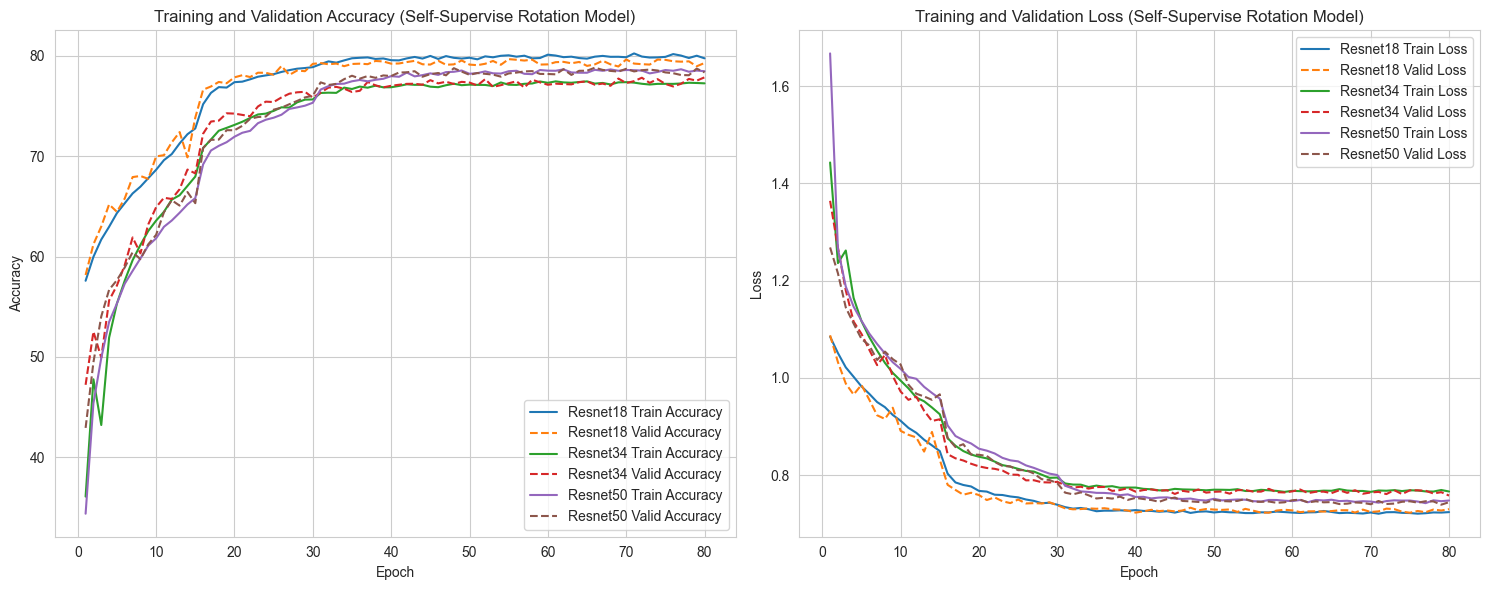

In [111]:
# Re-running the function without points on the plot
plot_model_performance_no_points(total_model_report, 'Self-Supervise Rotation Model')

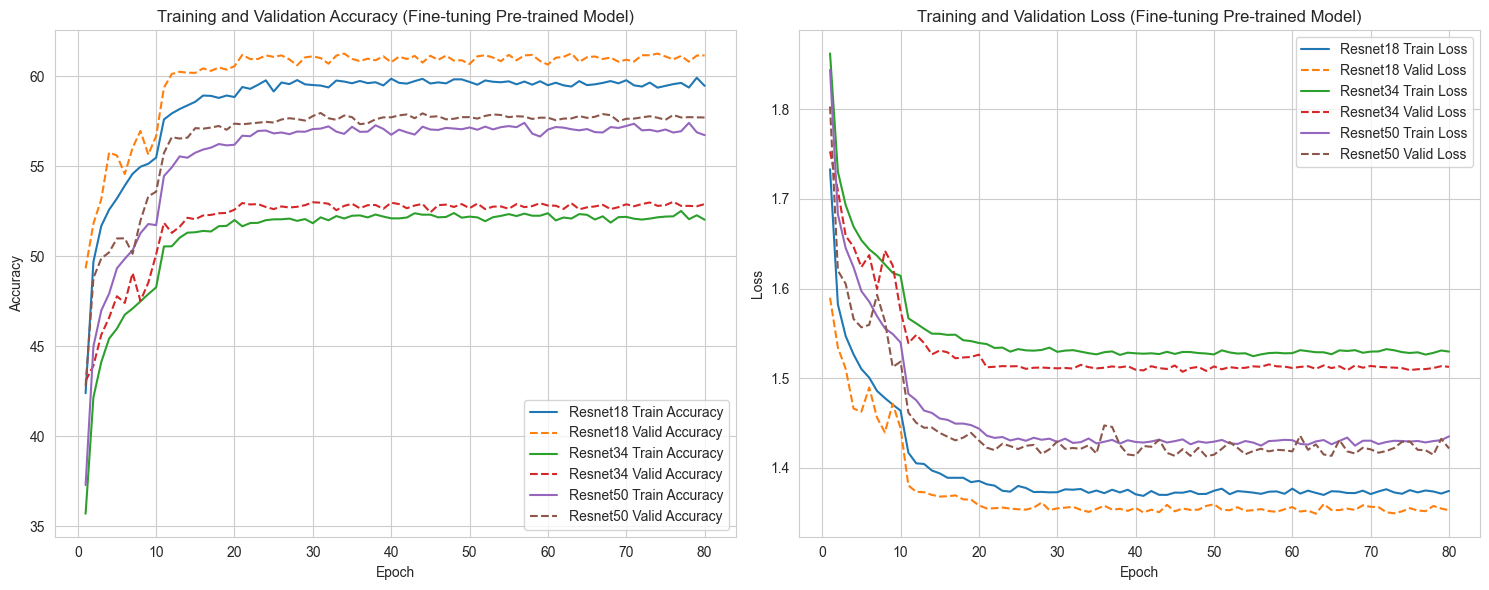

In [112]:
# Re-running the function without points on the plot
plot_model_performance_no_points(total_model_report, 'Fine-tuning Pre-trained Model')

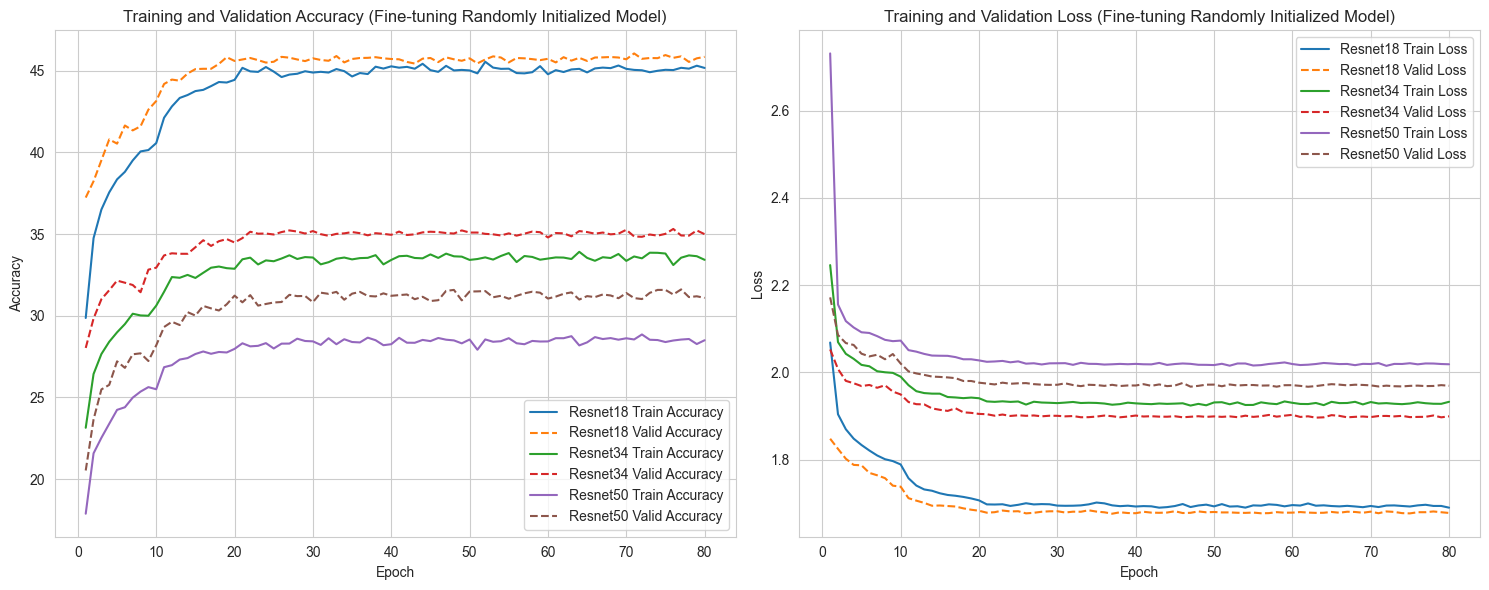

In [113]:
# Re-running the function without points on the plot
plot_model_performance_no_points(total_model_report, 'Fine-tuning Randomly Initialized Model')

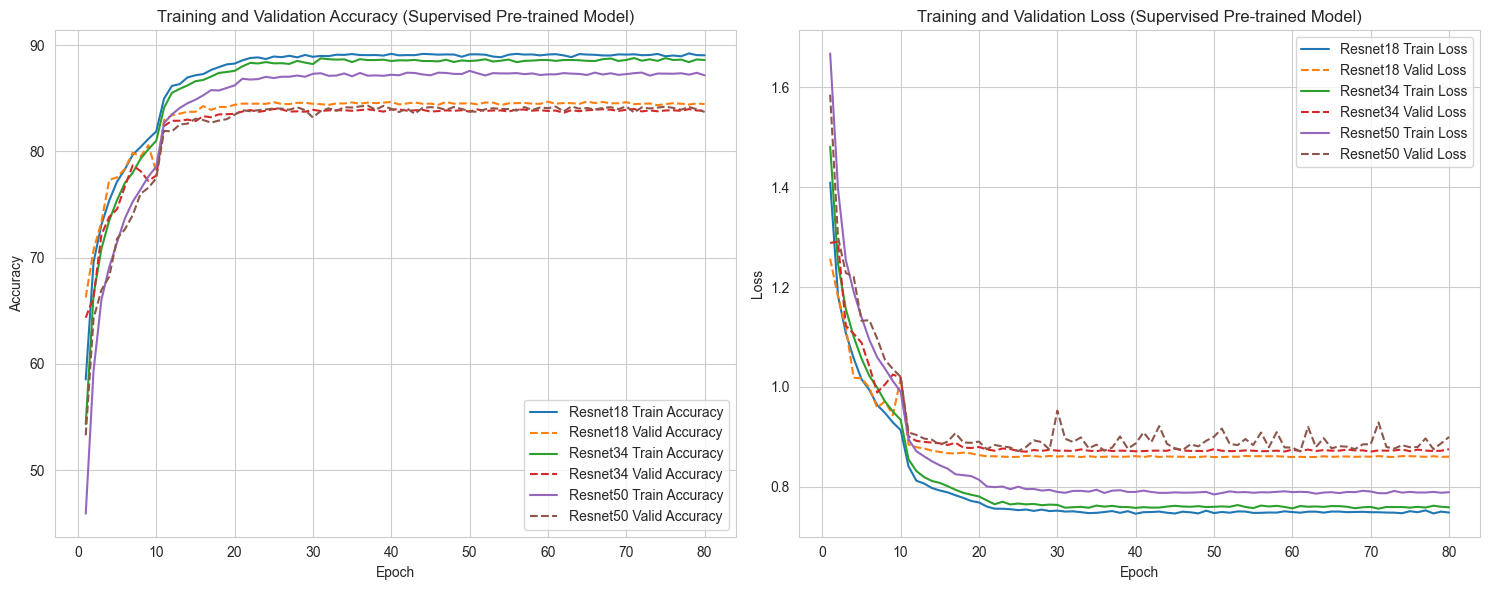

In [114]:
# Re-running the function without points on the plot
plot_model_performance_no_points(total_model_report, 'Supervised Pre-trained Model')

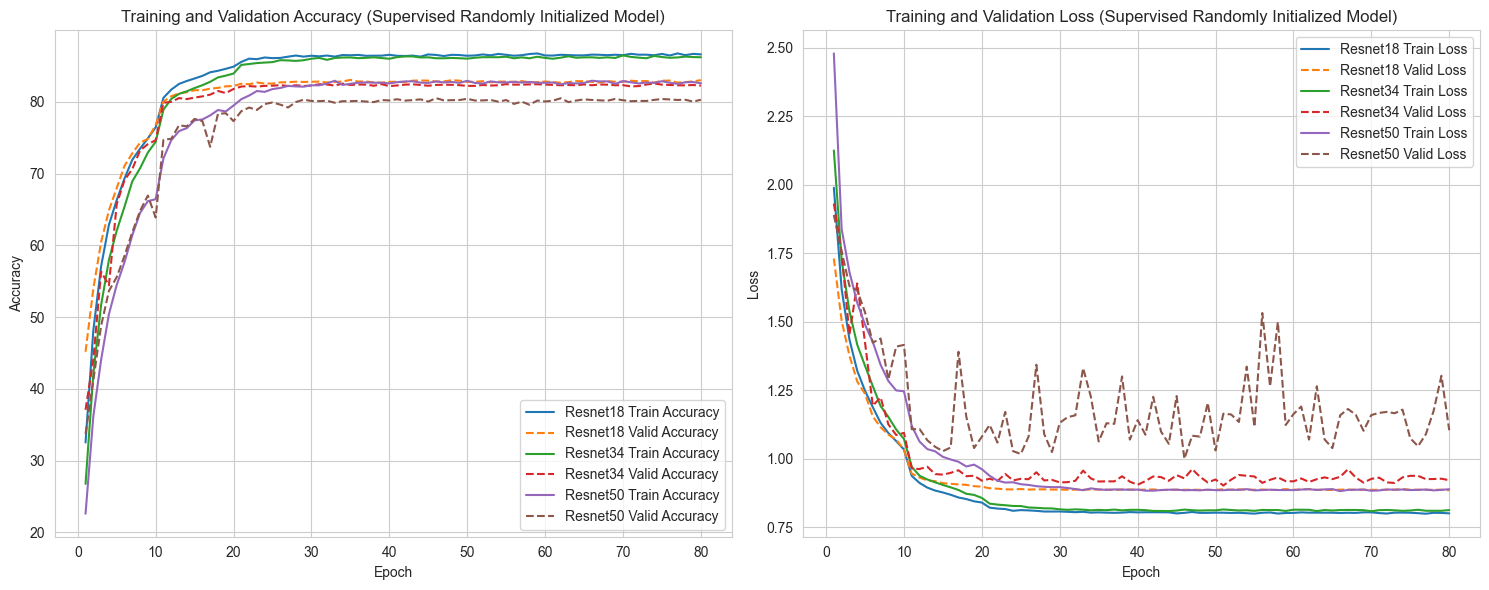

In [115]:
# Re-running the function without points on the plot
plot_model_performance_no_points(total_model_report, 'Supervised Randomly Initialized Model')

In [119]:
# Creating a copy of the report DataFrame
data = total_model_report.copy()

# Using a lambda function to split 'Experiment Type' into two new columns 'Model Type' and 'Experience Type'
data['Model Type'] = data['Experiment Type'].apply(lambda x: x.split()[0])
data['Experience Type'] = data['Experiment Type'].apply(lambda x: ' '.join(x.split()[1:]))

# Finding the maximum accuracy for each model and experience type
max_accuracy_data = data.groupby(['Experience Type', 'Model Type']).agg({'Valid Accuracy': 'max'}).reset_index()

# Creating the pivot table
pivot_df = max_accuracy_data.pivot(index='Experience Type', columns='Model Type', values='Valid Accuracy')

pivot_df.head()  # Displaying the first few rows of the pivot table

Model Type,Resnet18,Resnet34,Resnet50
Experience Type,,,
Fine-tuning Pre-trained Model,61.27,53.03,57.96
Fine-tuning Randomly Initialized Model,46.05,35.31,31.61
Self-Supervise Rotation Model,79.65,77.84,78.80
Supervised Pre-trained Model,84.70,84.00,84.32
Supervised Randomly Initialized Model,83.06,82.57,80.52


In [120]:
# Specifying the desired order for the experience types
experience_order = [
    "Self-Supervise Rotation Model",
    "Fine-tuning Pre-trained Model",
    "Fine-tuning Randomly Initialized Model",
    "Supervised Pre-trained Model",
    "Supervised Randomly Initialized Model"
]

# Reordering the pivot table according to the specified order
pivot_df = pivot_df.reindex(experience_order)

pivot_df.head()  # Displaying the pivot table with the new order

Model Type,Resnet18,Resnet34,Resnet50
Experience Type,,,
Self-Supervise Rotation Model,79.65,77.84,78.80
Fine-tuning Pre-trained Model,61.27,53.03,57.96
Fine-tuning Randomly Initialized Model,46.05,35.31,31.61
Supervised Pre-trained Model,84.70,84.00,84.32
Supervised Randomly Initialized Model,83.06,82.57,80.52


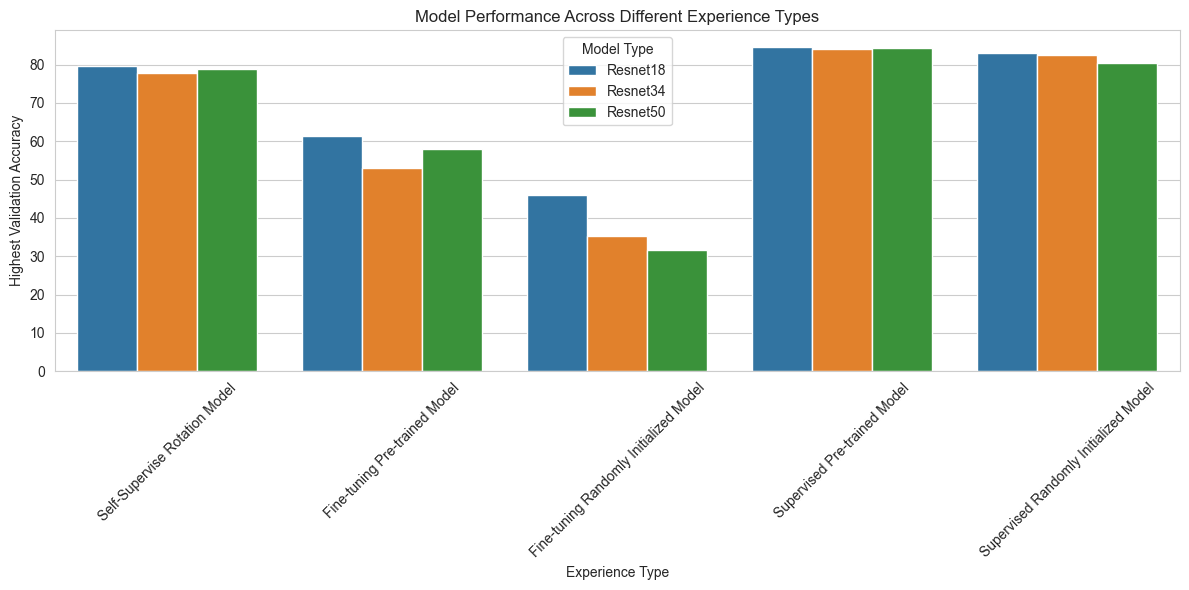

In [123]:
# Melting the original pivot_df to a format suitable for seaborn barplot
melted_data_all = pivot_df.reset_index().melt(id_vars='Experience Type', var_name='Model Type', value_name='Valid Accuracy')

# Bar plot with all Experience Types and Model Type as hue
plt.figure(figsize=(12, 6))
sns.barplot(x='Experience Type', y='Valid Accuracy', hue='Model Type', data=melted_data_all)

plt.title('Model Performance Across Different Experience Types')
plt.xlabel('Experience Type')
plt.ylabel('Highest Validation Accuracy')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.legend(title='Model Type')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Plot/Different Model Performance.png')
plt.show()